### Cell 1: Setup - Importing Libraries and Configuration

This cell initializes the project environment.
*   **Essential Libraries:** Imports core libraries like `pandas` for data manipulation, `numpy` for numerical operations, and `datetime` for handling dates.
*   **Machine Learning:** Imports necessary components from `sklearn` for:
    *   Model selection (`train_test_split`, `cross_val_score`)
    *   Classification algorithms (`RandomForestClassifier`, `GradientBoostingClassifier`, `LogisticRegression`)
    *   Model evaluation metrics (`accuracy_score`, `f1_score`, `roc_auc_score`, `confusion_matrix`, etc.)
    *   Data preprocessing (`LabelEncoder`, `StandardScaler`).
*   **Visualization:** Imports `matplotlib.pyplot` and `seaborn` for creating plots.
*   **Configuration:** Defines variables holding the file paths for the historical matches (`matches.csv`), historical deliveries (`deliveries.csv`), the IPL 2025 schedule (`ipl-2025-UTC.csv`), the output report file (`report_enhanced.md`), and the output predictions CSV (`ipl_2025_predictions.csv`). **Ensure these file paths are correct for your environment.**
*   **Settings:** Configures `warnings` to be ignored and sets a default plotting style using `seaborn`.
*   Finally, it prints a confirmation message that the setup is complete.

In [1]:
# --- Essential Libraries ---
import pandas as pd
import numpy as np
import datetime
import warnings

# --- Machine Learning ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve)
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Configuration ---
HISTORICAL_MATCHES_FILE = 'matches.csv' # <<< UPDATE WITH YOUR FULL MATCHES.CSV PATH >>>
HISTORICAL_DELIVERIES_FILE = 'deliveries.csv' # <<< UPDATE WITH YOUR FULL DELIVERIES.CSV PATH >>>
IPL_2025_SCHEDULE_FILE = 'ipl-2025-UTC.csv' # <<< UPDATE WITH YOUR FULL SCHEDULE CSV PATH >>>
OUTPUT_REPORT_FILE = 'report_enhanced.md'
OUTPUT_PREDICTIONS_CSV = 'ipl_2025_predictions.csv' # File to save predictions

# --- Settings ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')

print("Libraries imported and configuration set.")

Libraries imported and configuration set.


### Cell 2: Data Loading

This cell loads the datasets required for the analysis and prediction.
*   It uses `pandas.read_csv()` to read the three input CSV files specified in the configuration cell:
    *   `HISTORICAL_MATCHES_FILE` (`matches.csv`)
    *   `HISTORICAL_DELIVERIES_FILE` (`deliveries.csv`)
    *   `IPL_2025_SCHEDULE_FILE` (`ipl-2025-UTC.csv`)
*   It creates copies of the original DataFrames (`_raw`) into working DataFrames (`matches_df`, `deliveries_df`, `schedule_df`) to avoid modifying the raw data.
*   It prints the number of records loaded from each file for verification.
*   Includes basic error handling (`try-except`) to catch `FileNotFoundError` or other loading issues.

In [2]:
# --- 1. Data Loading ---
print("--- Loading Data ---")
try:
    matches_df_raw = pd.read_csv(HISTORICAL_MATCHES_FILE)
    deliveries_df_raw = pd.read_csv(HISTORICAL_DELIVERIES_FILE)
    schedule_df_raw = pd.read_csv(IPL_2025_SCHEDULE_FILE)
    
    # Make copies to work with, preserving originals
    matches_df = matches_df_raw.copy()
    deliveries_df = deliveries_df_raw.copy()
    schedule_df = schedule_df_raw.copy()

    print(f"Loaded {len(matches_df)} historical matches.")
    print(f"Loaded {len(deliveries_df)} delivery records.")
    print(f"Loaded {len(schedule_df)} scheduled matches for 2025.")
except FileNotFoundError as e:
    print(f"Error loading file: {e}. Please ensure CSV files are in the correct path.")
    # Optionally exit if running as a script, or raise error in notebook
    # exit() 
    raise e 
except Exception as e:
    print(f"An error occurred during file loading: {e}")
    # exit()
    raise e

--- Loading Data ---
Loaded 1095 historical matches.
Loaded 260920 delivery records.
Loaded 74 scheduled matches for 2025.


### Cell 3: Team Name Standardization

This cell ensures consistency in team names across all loaded DataFrames, which is crucial for accurate merging and analysis.
*   It defines a function `standardize_team_names` that takes a DataFrame as input.
*   Inside the function, a dictionary `team_replacements` maps old or alternative team names (like 'Delhi Daredevils') to their current standard names (like 'Delhi Capitals').
*   The function identifies the relevant team name columns based on the DataFrame type (matches, deliveries, or schedule) and applies the replacements using `.replace()`.
*   This function is then called on `matches_df`, `deliveries_df`, and `schedule_df`.
*   Finally, it prints the unique team names found in each DataFrame *after* standardization to verify the process and check for any remaining inconsistencies or new teams in the schedule.

In [3]:
# --- 2. Preprocessing & Feature Engineering (Historical Data) ---
print("\n--- Preprocessing & Feature Engineering ---")

# Standardize Team Names Function
def standardize_team_names(df, is_deliveries=False):
    team_replacements = {
        'Delhi Daredevils': 'Delhi Capitals',
        'Kings XI Punjab': 'Punjab Kings',
        'Rising Pune Supergiant': 'Rising Pune Supergiants', # Keep consistent if this is intentional
        'Pune Warriors': 'Pune Warriors India' # Add more as needed based on data exploration
        # Example: 'Deccan Chargers': 'Sunrisers Hyderabad' # If you want to map old teams
    }
    cols_to_standardize = []
    # Define columns based on dataframe type
    if is_deliveries:
        cols_to_standardize = ['batting_team', 'bowling_team']
    elif 'Home Team' in df.columns: # Assuming schedule dataframe structure
         cols_to_standardize = ['Home Team', 'Away Team']
         # Add 'toss_winner', 'winner' if they exist in future schedule formats
    else: # Assuming historical matches dataframe structure
        cols_to_standardize = ['team1', 'team2', 'toss_winner', 'winner']

    for col in cols_to_standardize:
        if col in df.columns:
            # Use .loc to avoid SettingWithCopyWarning if df is a slice
            df.loc[:, col] = df[col].replace(team_replacements)
    return df

print("Standardizing team names...")
matches_df = standardize_team_names(matches_df)
deliveries_df = standardize_team_names(deliveries_df, is_deliveries=True)
# Standardize schedule_df using its specific column names
schedule_df = standardize_team_names(schedule_df) # Assumes 'Home Team', 'Away Team' exist
print("Team name standardization complete.")
print("\nUnique teams in matches_df after standardization:", sorted(pd.concat([matches_df['team1'], matches_df['team2']]).unique()))
print("Unique teams in deliveries_df after standardization:", sorted(pd.concat([deliveries_df['batting_team'], deliveries_df['bowling_team']]).unique()))
print("Unique teams in schedule_df after standardization:", sorted(pd.concat([schedule_df['Home Team'], schedule_df['Away Team']]).unique()))


--- Preprocessing & Feature Engineering ---
Standardizing team names...
Team name standardization complete.

Unique teams in matches_df after standardization: ['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Gujarat Lions', 'Gujarat Titans', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians', 'Pune Warriors India', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad']
Unique teams in deliveries_df after standardization: ['Chennai Super Kings', 'Deccan Chargers', 'Delhi Capitals', 'Gujarat Lions', 'Gujarat Titans', 'Kochi Tuskers Kerala', 'Kolkata Knight Riders', 'Lucknow Super Giants', 'Mumbai Indians', 'Pune Warriors India', 'Punjab Kings', 'Rajasthan Royals', 'Rising Pune Supergiants', 'Royal Challengers Bangalore', 'Royal Challengers Bengaluru', 'Sunrisers Hyderabad']
Unique teams in schedule_df after standardization: ['Chennai Super King

### Cell 4: Basic Match Preprocessing (Historical Data)

This cell performs initial cleaning and feature creation on the historical `matches_df`.
*   **Date Conversion:** Converts the 'date' column to datetime objects using `pd.to_datetime`, handling potential parsing errors.
*   **Dropping Invalid Matches:** Removes rows where the 'winner' or 'date' is missing, as these matches cannot be used reliably for training.
*   **Handling Missing Cities:** Fills any missing values in the 'city' column with the string 'Unknown'.
*   **Column Selection:** Selects only the columns relevant for the analysis and prediction tasks.
*   **Basic Features:** Creates two new binary features:
    *   `team1_toss_win`: 1 if team1 won the toss, 0 otherwise.
    *   `team1_win`: 1 if team1 won the match, 0 otherwise (this will be a target variable).
*   Displays the first few rows (`.head()`) of the processed `matches_df`.

In [4]:
print("Performing basic preprocessing on matches data...")
# Basic Preprocessing on Matches
matches_df['date'] = pd.to_datetime(matches_df['date'], errors='coerce')
# Drop matches with no winner or invalid date BEFORE filling city NaNs
matches_df.dropna(subset=['winner', 'date'], inplace=True)
matches_df['city'].fillna('Unknown', inplace=True) # Fill NaNs after dropping rows where winner is NaN

# Select relevant columns and create basic features
matches_df = matches_df[['id', 'season', 'city', 'date', 'venue', 'team1', 'team2',
                         'toss_winner', 'toss_decision', 'winner']].copy() # Use .copy()
matches_df['team1_toss_win'] = (matches_df['toss_winner'] == matches_df['team1']).astype(int)
matches_df['team1_win'] = (matches_df['winner'] == matches_df['team1']).astype(int)
print("Basic match preprocessing complete.")
matches_df.head()

Performing basic preprocessing on matches data...
Basic match preprocessing complete.


,id,season,city,date,venue,team1,team2,toss_winner,toss_decision,winner,team1_toss_win,team1_win
0,335982,2007/08,Bangalore,2008-04-18,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,1,0
1,335983,2007/08,Chandigarh,2008-04-19,"Punjab Cricket Association Stadium, Mohali",Punjab Kings,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,0,0
2,335984,2007/08,Delhi,2008-04-19,Feroz Shah Kotla,Delhi Capitals,Rajasthan Royals,Rajasthan Royals,bat,Delhi Capitals,0,1
3,335985,2007/08,Mumbai,2008-04-20,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,1,0
4,335986,2007/08,Kolkata,2008-04-20,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,0,1


### Cell 5: Feature Engineering from Deliveries (Aggregates)

This cell calculates aggregated statistics *per inning* for each match using the detailed ball-by-ball `deliveries_df`. These stats provide insights into team performance within a match but are *not* directly used as features in the *final* simplified model in this notebook (the final model uses overall averages from the next cell).
*   **Batting Stats:** Groups the data by match, inning, and batting team to calculate:
    *   `inning_runs`: Total runs scored by the batting team in that inning.
    *   `balls_faced`: Total legal balls faced by the batting team in that inning.
*   **Bowling Stats:** Groups the data by match, inning, and bowling team to calculate:
    *   `runs_conceded`: Total runs conceded by the bowling team in that inning.
    *   `wickets_taken`: Total wickets taken by the bowling team in that inning.
    *   `balls_bowled`: Total legal balls bowled by the bowling team in that inning.
*   Stores these aggregates in `batting_stats` and `bowling_stats` DataFrames and displays their first few rows.

In [5]:
# --- Feature Engineering from Deliveries ---
print("Calculating aggregated features from deliveries data...")

# Calculate overall runs scored and balls faced per match by batting team
batting_stats = deliveries_df.groupby(['match_id', 'inning', 'batting_team']).agg(
    inning_runs=('total_runs', 'sum'),
    balls_faced=('ball', 'count') # Count balls legally bowled in the inning
).reset_index()

# Calculate overall runs conceded and wickets taken per match by bowling team
bowling_stats = deliveries_df.groupby(['match_id', 'inning', 'bowling_team']).agg(
    runs_conceded=('total_runs', 'sum'),
    wickets_taken=('is_wicket', 'sum'),
    balls_bowled=('ball', 'count') # Approximation, better than just using batting balls faced
).reset_index()

print("Delivery stats aggregates calculated.")
print("Batting Stats Head:\n", batting_stats.head())
print("\nBowling Stats Head:\n", bowling_stats.head())

Calculating aggregated features from deliveries data...
Delivery stats aggregates calculated.
Batting Stats Head:
    match_id  inning                 batting_team  inning_runs  balls_faced
0    335982       1        Kolkata Knight Riders          222          124
1    335982       2  Royal Challengers Bangalore           82          101
2    335983       1          Chennai Super Kings          240          124
3    335983       2                 Punjab Kings          207          124
4    335984       1             Rajasthan Royals          129          122

Bowling Stats Head:
    match_id  inning                 bowling_team  runs_conceded  \
0    335982       1  Royal Challengers Bangalore            222   
1    335982       2        Kolkata Knight Riders             82   
2    335983       1                 Punjab Kings            240   
3    335983       2          Chennai Super Kings            207   
4    335984       1               Delhi Capitals            129   

   wickets

### Cell 6: Overall Team Average Statistics (Historical)

This cell calculates *overall* historical average performance metrics for each team based on the entire `deliveries_df`. These averages serve as simple features representing a team's general historical strength.
*   **Team Batting Averages:**
    *   Groups `deliveries_df` by `batting_team`.
    *   Calculates `total_runs_scored` and `total_balls_faced` for each team.
    *   Computes `overall_avg_sr` (Overall Average Strike Rate = runs/balls * 100).
*   **Team Bowling Averages:**
    *   Groups `deliveries_df` by `bowling_team`.
    *   Calculates `total_runs_conceded`, `total_wickets_taken`, and `total_balls_bowled`.
    *   Computes `overall_avg_econ` (Overall Average Economy Rate = runs_conceded / (balls_bowled / 6)).
    *   Computes `overall_avg_wicket_rate` (Overall Average Balls per Wicket = balls_bowled / wickets_taken).
*   Handles potential division-by-zero cases (e.g., if a team bowled 0 balls or took 0 wickets).
*   Stores results in `team_batting_avg` and `team_bowling_avg` DataFrames and displays their heads.
*   *Note: These are simple overall averages. More complex models might use rolling averages or season-specific averages.*

In [6]:
print("Calculating overall team average statistics...")
# Calculate *overall* team averages (simplification - rolling averages would be better)

# Team Batting Averages
team_batting_avg = deliveries_df.groupby('batting_team').agg(
    total_runs_scored=('total_runs', 'sum'),
    # Count only legal balls for strike rate
    total_balls_faced=pd.NamedAgg(column='ball', aggfunc='count') # Use wide='0' exclusion later if needed
).reset_index()
# Avoid division by zero if a team somehow faced 0 balls (unlikely but safe)
team_batting_avg['overall_avg_sr'] = np.where(
    team_batting_avg['total_balls_faced'] > 0,
    (team_batting_avg['total_runs_scored'] / team_batting_avg['total_balls_faced']) * 100,
    0
)


# Team Bowling Averages
team_bowling_avg = deliveries_df.groupby('bowling_team').agg(
    total_runs_conceded=('total_runs', 'sum'),
    total_wickets_taken=('is_wicket', 'sum'),
    # Count only legal balls for economy
    total_balls_bowled = pd.NamedAgg(column='ball', aggfunc='count') # Use wide='0' exclusion later if needed
).reset_index()

# Avoid division by zero for economy and wicket rate
team_bowling_avg['overall_avg_econ'] = np.where(
    team_bowling_avg['total_balls_bowled'] > 0,
    (team_bowling_avg['total_runs_conceded'] * 6) / team_bowling_avg['total_balls_bowled'],
    np.nan # Or perhaps a large number like 36 if 0 balls bowled means infinite economy? NaN is safer.
)
team_bowling_avg['overall_avg_wicket_rate'] = np.where(
    team_bowling_avg['total_wickets_taken'] > 0,
    team_bowling_avg['total_balls_bowled'] / team_bowling_avg['total_wickets_taken'],
    np.nan # If 0 wickets, strike rate is effectively infinite, NaN represents this
)

print("Overall team averages calculated.")
print("\nTeam Batting Avg Head:\n", team_batting_avg.head())
print("\nTeam Bowling Avg Head:\n", team_bowling_avg.head())

Calculating overall team average statistics...
Overall team averages calculated.

Team Batting Avg Head:
           batting_team  total_runs_scored  total_balls_faced  overall_avg_sr
0  Chennai Super Kings              38629              28651      134.826010
1      Deccan Chargers              11463               9034      126.887315
2       Delhi Capitals              39196              29732      131.831024
3        Gujarat Lions               4862               3566      136.343242
4       Gujarat Titans               7757               5494      141.190390

Team Bowling Avg Head:
           bowling_team  total_runs_conceded  total_wickets_taken  \
0  Chennai Super Kings                37207                 1481   
1      Deccan Chargers                11618                  446   
2       Delhi Capitals                40125                 1498   
3        Gujarat Lions                 5090                  151   
4       Gujarat Titans                 7475                  298   

### Cell 7: Merging Averages into Matches Data

This cell adds the calculated overall team statistics (from Cell 6) as features to the main historical `matches_df`.
*   It performs four separate merge operations:
    *   Merges batting average strike rate (`overall_avg_sr`) for `team1`.
    *   Merges bowling average economy and wicket rate (`overall_avg_econ`, `overall_avg_wicket_rate`) for `team1`.
    *   Merges batting average strike rate (`overall_avg_sr`) for `team2`.
    *   Merges bowling average economy and wicket rate (`overall_avg_econ`, `overall_avg_wicket_rate`) for `team2`.
*   After each merge, columns are appropriately renamed (e.g., `team1_overall_avg_sr`, `team2_overall_avg_econ`).
*   **NaN Handling:** It fills any potential missing values (NaNs) that might arise if a team in `matches_df` didn't have corresponding stats in the average DataFrames (unlikely with this setup but good practice). It fills these NaNs using the *mean* value of that respective column calculated from the `matches_df` itself.
*   Displays the head of the newly added statistical columns along with the team names for verification.

In [7]:
print("Merging overall team averages into matches data...")

# Merge overall stats into matches_df
# Merge Team 1 Stats
matches_df = matches_df.merge(team_batting_avg[['batting_team', 'overall_avg_sr']],
                              left_on='team1', right_on='batting_team', how='left')
matches_df.rename(columns={'overall_avg_sr': 'team1_overall_avg_sr'}, inplace=True)
matches_df.drop('batting_team', axis=1, inplace=True)

matches_df = matches_df.merge(team_bowling_avg[['bowling_team', 'overall_avg_econ', 'overall_avg_wicket_rate']],
                              left_on='team1', right_on='bowling_team', how='left')
matches_df.rename(columns={'overall_avg_econ': 'team1_overall_avg_econ',
                           'overall_avg_wicket_rate': 'team1_overall_avg_wicket_rate'}, inplace=True)
matches_df.drop('bowling_team', axis=1, inplace=True)

# Merge Team 2 Stats
matches_df = matches_df.merge(team_batting_avg[['batting_team', 'overall_avg_sr']],
                              left_on='team2', right_on='batting_team', how='left')
matches_df.rename(columns={'overall_avg_sr': 'team2_overall_avg_sr'}, inplace=True)
matches_df.drop('batting_team', axis=1, inplace=True)

matches_df = matches_df.merge(team_bowling_avg[['bowling_team', 'overall_avg_econ', 'overall_avg_wicket_rate']],
                              left_on='team2', right_on='bowling_team', how='left')
matches_df.rename(columns={'overall_avg_econ': 'team2_overall_avg_econ',
                           'overall_avg_wicket_rate': 'team2_overall_avg_wicket_rate'}, inplace=True)
matches_df.drop('bowling_team', axis=1, inplace=True)

# Fill potential NaNs in merged stats (e.g., if a team only exists in matches but not deliveries)
stat_cols = ['team1_overall_avg_sr', 'team2_overall_avg_sr', 'team1_overall_avg_econ',
             'team2_overall_avg_econ', 'team1_overall_avg_wicket_rate', 'team2_overall_avg_wicket_rate']
for col in stat_cols:
    if col in matches_df.columns:
        mean_val = matches_df[col].mean() # Calculate mean once
        matches_df[col].fillna(mean_val, inplace=True)
        print(f"Filled NaNs in '{col}' with mean value: {mean_val:.2f}")

print("Delivery features merged and NaNs handled.")
matches_df[stat_cols + ['team1', 'team2']].head()

Merging overall team averages into matches data...
Filled NaNs in 'team1_overall_avg_sr' with mean value: 133.30
Filled NaNs in 'team2_overall_avg_sr' with mean value: 133.23
Filled NaNs in 'team1_overall_avg_econ' with mean value: 8.00
Filled NaNs in 'team2_overall_avg_econ' with mean value: 8.00
Filled NaNs in 'team1_overall_avg_wicket_rate' with mean value: 20.18
Filled NaNs in 'team2_overall_avg_wicket_rate' with mean value: 20.18
Delivery features merged and NaNs handled.


,team1_overall_avg_sr,team2_overall_avg_sr,team1_overall_avg_econ,team2_overall_avg_econ,team1_overall_avg_wicket_rate,team2_overall_avg_wicket_rate,team1,team2
0,133.635880,133.262181,8.036039,7.906011,20.169275,20.261612,Royal Challengers Bangalore,Kolkata Knight Riders
1,134.332915,134.826010,8.219848,7.812220,20.695960,19.295071,Punjab Kings,Chennai Super Kings
2,131.831024,132.409877,8.040814,7.977149,19.987316,20.698512,Delhi Capitals,Rajasthan Royals
3,134.160384,133.635880,7.864656,8.036039,19.802011,20.169275,Mumbai Indians,Royal Challengers Bangalore
4,133.262181,126.887315,7.906011,7.711915,20.261612,20.266816,Kolkata Knight Riders,Deccan Chargers


### Cell 8: Encoding Categorical Features

This cell converts categorical features (text data like team names, venues) into numerical representations, which are required by most machine learning algorithms.
*   It identifies the categorical columns to be encoded in `matches_df`: `venue`, `team1`, `team2`, `toss_winner`, `toss_decision`.
*   It creates a dictionary `encoders` to store the `LabelEncoder` object fitted for each column.
*   **Crucially, for robust encoding that works for both historical and future (schedule) data:**
    *   It iterates through each categorical column.
    *   It gathers all unique values for that category from *both* the historical `matches_df` and the `schedule_df`.
    *   A `LabelEncoder` is then `fit` on this combined set of all possible values.
    *   The `matches_df` column is then `transform`ed using the fitted encoder, creating a new numerical column (e.g., `venue_encoded`).
    *   The fitted encoder is stored in the `encoders` dictionary for later use on the schedule data.
*   Prints confirmation messages for each encoded column, showing the number of unique values found across both datasets.
*   Displays the head of the original and newly encoded columns for `venue`, `team1`, and `team2`.

In [8]:
# --- Encoding Categorical Features ---
print("Encoding categorical features...")
encoders = {}
# Include 'city' if using it as a feature, removed 'winner' as it's a target
categorical_cols_matches = ['venue', 'team1', 'team2', 'toss_winner', 'toss_decision']
# Define corresponding columns in the schedule dataframe
schedule_col_map = {'venue': 'Location', 'team1': 'Home Team', 'team2': 'Away Team',
                    'toss_winner': None, 'toss_decision': None} # Toss info not in schedule

# Combine values from historical and schedule for robust encoding
for col in categorical_cols_matches:
    if col in matches_df.columns:
        le = LabelEncoder()
        schedule_col = schedule_col_map.get(col)

        present_in_schedule = schedule_col and schedule_col in schedule_df.columns
        
        # Ensure data types are consistent (string) before concatenation/fitting
        historical_values = matches_df[col].astype(str).unique()
        
        if present_in_schedule:
             schedule_values = schedule_df[schedule_col].astype(str).unique()
             all_values = np.concatenate([historical_values, schedule_values])
             all_values = pd.Series(all_values).unique() # Get unique values across both
        else:
             all_values = historical_values # Only historical if not in schedule

        le.fit(all_values)
        matches_df[f'{col}_encoded'] = le.transform(matches_df[col].astype(str))
        encoders[col] = le
        print(f"Encoded '{col}'. Found {len(all_values)} unique values.")
        # print(f" Classes for '{col}': {le.classes_}") # Uncomment to inspect classes

# Encode the target variable 'winner' separately if needed, but we use team1_win which is already 0/1
# le_winner = LabelEncoder()
# le_winner.fit(matches_df['winner'].astype(str).unique())
# matches_df['winner_encoded'] = le_winner.transform(matches_df['winner'].astype(str))
# encoders['winner'] = le_winner

print("Encoding complete.")
matches_df[['venue', 'venue_encoded', 'team1', 'team1_encoded', 'team2', 'team2_encoded']].head()

Encoding categorical features...
Encoded 'venue'. Found 63 unique values.
Encoded 'team1'. Found 17 unique values.
Encoded 'team2'. Found 17 unique values.
Encoded 'toss_winner'. Found 16 unique values.
Encoded 'toss_decision'. Found 2 unique values.
Encoding complete.


,venue,venue_encoded,team1,team1_encoded,team2,team2_encoded
0,M Chinnaswamy Stadium,26,Royal Challengers Bangalore,13,Kolkata Knight Riders,6
1,"Punjab Cricket Association Stadium, Mohali",45,Punjab Kings,10,Chennai Super Kings,0
2,Feroz Shah Kotla,19,Delhi Capitals,2,Rajasthan Royals,11
3,Wankhede Stadium,60,Mumbai Indians,8,Royal Challengers Bangalore,13
4,Eden Gardens,17,Kolkata Knight Riders,6,Deccan Chargers,1


### Cell 9: Data Splitting (for Model Evaluation)

This cell prepares the data for model training and evaluation by defining features/targets and splitting the historical data.
*   **Feature/Target Definition:**
    *   Defines the list of feature columns (`toss_features`, `match_features`) and the target variable column (`toss_target`, `match_target`) for both the Toss Prediction and Match Winner Prediction tasks. `match_features` includes both encoded categorical columns and the numerical team average statistics.
*   **Feature Matrix/Target Vector Creation:** Creates the `X` (features) and `y` (target) DataFrames/Series for both tasks from the prepared `matches_df`.
*   **NaN Check:** Performs a check for any remaining NaN values in the created X and y sets.
*   **Train-Validation Split:** Uses `sklearn.model_selection.train_test_split` to divide the historical data (`X_toss`, `y_toss`, `X_match`, `y_match`) into:
    *   Training sets (`_train`): Used to train the models (75% of the data).
    *   Validation sets (`_val`): Used to evaluate the trained models' performance on unseen historical data (25% of the data).
*   **Stratification:** Uses `stratify=y` to ensure that the proportion of classes (e.g., team1 wins vs. team2 wins) is approximately the same in both the training and validation sets, which is important for potentially imbalanced datasets.
*   Prints the sizes of the resulting training and validation sets.

In [9]:
# --- 3. Data Splitting (Historical Data for Evaluation) ---
print("\n--- Splitting Data for Model Evaluation ---")

# Define features and targets
# Toss Features (Simpler model, less dependent on delivery stats)
toss_features = ['venue_encoded', 'team1_encoded', 'team2_encoded']
toss_target = 'team1_toss_win' # Predict if team1 wins the toss (binary)

# Match Features (Include delivery stats)
match_features_categorical = ['venue_encoded', 'team1_encoded', 'team2_encoded',
                              'toss_winner_encoded', 'toss_decision_encoded']
match_features_numerical = ['team1_overall_avg_sr', 'team2_overall_avg_sr', 'team1_overall_avg_econ',
                            'team2_overall_avg_econ', 'team1_overall_avg_wicket_rate', 'team2_overall_avg_wicket_rate']
match_features = match_features_categorical + match_features_numerical
match_target = 'team1_win' # Predict if team1 wins the match (binary)

# Ensure all features exist in the dataframe
missing_toss_features = [f for f in toss_features if f not in matches_df.columns]
missing_match_features = [f for f in match_features if f not in matches_df.columns]
if missing_toss_features:
    print(f"Error: Missing required toss features: {missing_toss_features}")
    # Raise error or handle appropriately
    raise ValueError(f"Missing required toss features: {missing_toss_features}")
if missing_match_features:
    print(f"Error: Missing required match features: {missing_match_features}")
    raise ValueError(f"Missing required match features: {missing_match_features}")

# Prepare final feature matrix and target vector
X_toss = matches_df[toss_features].copy()
y_toss = matches_df[toss_target].copy()
X_match = matches_df[match_features].copy()
y_match = matches_df[match_target].copy()

# Check for NaNs introduced during feature creation or merging before splitting
print(f"NaNs in X_toss: {X_toss.isnull().sum().sum()}")
print(f"NaNs in y_toss: {y_toss.isnull().sum().sum()}")
print(f"NaNs in X_match: {X_match.isnull().sum().sum()}")
print(f"NaNs in y_match: {y_match.isnull().sum().sum()}")
# If NaNs exist, they need to be handled here (e.g., imputation or row removal)
# X_toss.fillna(X_toss.median(), inplace=True) # Example: Impute with median
# X_match.fillna(X_match.median(), inplace=True) # Example: Impute with median

# Split into Training and Validation sets
# Stratify ensures proportion of target classes is maintained in train/test sets
X_toss_train, X_toss_val, y_toss_train, y_toss_val = train_test_split(
    X_toss, y_toss, test_size=0.25, random_state=42, stratify=y_toss)

X_match_train, X_match_val, y_match_train, y_match_val = train_test_split(
    X_match, y_match, test_size=0.25, random_state=42, stratify=y_match)

print(f"\nTraining set size: Toss={len(X_toss_train)}, Match={len(X_match_train)}")
print(f"Validation set size: Toss={len(X_toss_val)}, Match={len(X_match_val)}")


--- Splitting Data for Model Evaluation ---
NaNs in X_toss: 0
NaNs in y_toss: 0
NaNs in X_match: 0
NaNs in y_match: 0

Training set size: Toss=817, Match=817
Validation set size: Toss=273, Match=273


### Cell 10: Scaling Numerical Features (for Evaluation Split)

This cell applies feature scaling specifically to the *numerical* features used in the *match winner prediction* model. Scaling helps algorithms like Logistic Regression perform better by ensuring all features have a similar range, preventing features with larger values from dominating.
*   Initializes a `StandardScaler` object.
*   **Fit on Training Data Only:** Fits the scaler *only* on the numerical features (`match_features_numerical`) of the *training set* (`X_match_train`). This prevents data leakage from the validation set.
*   **Transform Both Sets:** Uses the *fitted* scaler to transform (scale) the numerical features in *both* the training set (`X_match_train`) and the validation set (`X_match_val`).
*   Displays the head of the scaled numerical features in the training set.
*   Includes a note explaining that scaling is not applied to the toss prediction features in this specific setup, as they are label-encoded categories and tree-based models (like Random Forest) are less sensitive to feature scaling.

In [10]:
# --- Scaling Numerical Features (Important for Logistic Regression) ---
print("Scaling numerical features for match prediction model...")

# Initialize the scaler
scaler = StandardScaler()

# Fit scaler ONLY on the training data's numerical features
scaler.fit(X_match_train[match_features_numerical])

# Transform both training and validation sets' numerical features
X_match_train[match_features_numerical] = scaler.transform(X_match_train[match_features_numerical])
X_match_val[match_features_numerical] = scaler.transform(X_match_val[match_features_numerical])

print("Numerical features scaled.")
print("\nScaled X_match_train numerical features head:\n", X_match_train[match_features_numerical].head())

# Note: No scaling needed for Toss model features as they are label encoded categories
# and tree-based models (RF, GB) are less sensitive to scaling. LR for toss might benefit,
# but we keep it simple here as toss prediction is often close to random chance.

Scaling numerical features for match prediction model...
Numerical features scaled.

Scaled X_match_train numerical features head:
       team1_overall_avg_sr  team2_overall_avg_sr  team1_overall_avg_econ  \
1025              0.364856              2.209685               -0.755871   
497               0.364856              0.284509               -0.755871   
501               0.364856             -0.194870               -0.755871   
818              -0.313573             -0.194870                0.189850   
1052              0.364856              1.630129               -0.755871   

      team2_overall_avg_econ  team1_overall_avg_wicket_rate  \
1025                2.253867                      -1.130933   
497                -0.599441                      -1.130933   
501                -0.060901                      -1.130933   
818                -0.060901                      -0.271337   
1052                2.505372                      -1.130933   

      team2_overall_avg_wicket_r

### Cell 11: Model Definition

This cell defines the candidate machine learning models that will be evaluated for both prediction tasks.
*   Creates a dictionary named `models`.
*   Initializes instances of three different classification algorithms:
    *   `LogisticRegression` (with increased `max_iter` for convergence and `class_weight='balanced'` to handle potential imbalance).
    *   `RandomForestClassifier` (with specific hyperparameters like `n_estimators`, `max_depth`, `min_samples_leaf`, and `class_weight='balanced'`).
    *   `GradientBoostingClassifier` (using common default parameters).
*   Sets `random_state=42` for all models to ensure reproducibility.
*   Initializes an empty list `results_list` which will be used in the following cells to store the evaluation metrics for each model. **It's crucial this list is cleared here before evaluation.**
*   Prints the names of the defined models.

In [11]:
# --- 4. Model Training and Evaluation ---
print("\n--- Defining Models and Preparing for Evaluation ---")

# Define models to evaluate
models = {
    # Increased max_iter for Logistic Regression convergence
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=150, max_depth=10, min_samples_leaf=5), # Tuned slightly
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3) # Common default
}

# List to store evaluation results
# !!! IMPORTANT: Ensure this line is executed to clear previous results before running the evaluation loops !!!
results_list = [] 

print(f"Models defined: {list(models.keys())}")
print("Results list initialized (cleared).")


--- Defining Models and Preparing for Evaluation ---
Models defined: ['Logistic Regression', 'Random Forest', 'Gradient Boosting']
Results list initialized (cleared).


### Cell 12: Evaluate Toss Prediction Models

This cell trains and evaluates each of the defined models specifically for the **Toss Winner Prediction** task using the train/validation split created earlier.
*   It loops through the `models` dictionary.
*   **Training:** For each model, it trains (`.fit()`) using the toss training data (`X_toss_train`, `y_toss_train`).
*   **Prediction:** It makes predictions (`.predict()`, `.predict_proba()`) on the toss validation set (`X_toss_val`).
*   **Metrics Calculation:** Calculates standard classification metrics:
    *   Accuracy
    *   Precision, Recall, F1-Score (using `average='weighted'` to account for class imbalance)
    *   ROC AUC Score (Area Under the Receiver Operating Characteristic Curve)
*   **Results Storage:** Appends the calculated metrics for the current model to the `results_list`.
*   **Output:** Prints the key metrics (Accuracy, F1, ROC AUC) for each model.
*   **ROC Curve Plotting:** Generates and displays a combined ROC curve plot, showing the performance of each model on the validation set. The Area Under the Curve (AUC) provides a measure of the model's ability to distinguish between the classes.
*   **Best Model Selection:** Tracks the model with the highest **weighted F1-score** on the validation set and stores its name (`best_toss_model_name`) and score (`best_toss_f1`).
*   Finally, it prints the name and F1-score of the selected best model for toss prediction.


--- Evaluating Toss Prediction Models ---
 Training and evaluating Logistic Regression for Toss Prediction...
  Logistic Regression - Accuracy: 0.5275, F1: 0.5327, ROC AUC: 0.4971
 Training and evaluating Random Forest for Toss Prediction...
  Random Forest - Accuracy: 0.5531, F1: 0.5572, ROC AUC: 0.5499
 Training and evaluating Gradient Boosting for Toss Prediction...
  Gradient Boosting - Accuracy: 0.5971, F1: 0.5423, ROC AUC: 0.5976


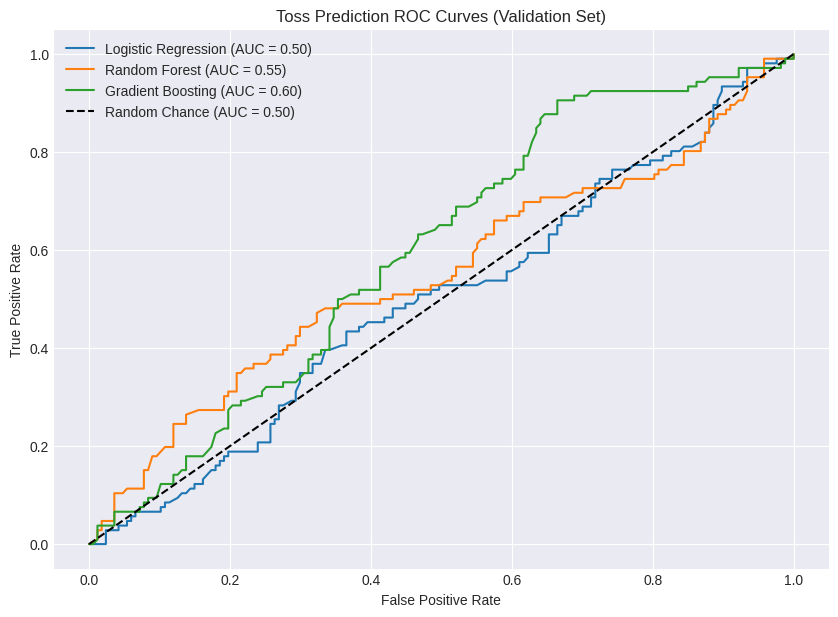


Best Toss Prediction Model (based on weighted F1): Random Forest with F1: 0.5572


In [12]:
# --- Evaluate Toss Prediction Models ---
print("\n--- Evaluating Toss Prediction Models ---")
best_toss_model_name = None
best_toss_f1 = -1

# Create figure for Toss ROC Curves
plt.figure(figsize=(10, 7))

for name, model in models.items():
    print(f" Training and evaluating {name} for Toss Prediction...")
    
    # Train the model (No scaling needed for toss features here)
    model.fit(X_toss_train, y_toss_train)
    
    # Make predictions on the validation set
    y_pred = model.predict(X_toss_val)
    # Get probabilities for the positive class (team1_toss_win=1) for ROC AUC
    try:
        y_pred_proba = model.predict_proba(X_toss_val)[:, 1]
        roc_auc_calculable = True
    except AttributeError:
        # Some models might not have predict_proba (though the ones used here do)
        print(f"  Warning: {name} does not have predict_proba. ROC AUC cannot be calculated.")
        y_pred_proba = y_pred # Use hard predictions if no proba
        roc_auc = np.nan # Assign NaN if ROC AUC cannot be calculated
        roc_auc_calculable = False


    # Calculate metrics
    accuracy = accuracy_score(y_toss_val, y_pred)
    # Use 'weighted' average for precision/recall/F1 for potentially imbalanced classes
    precision = precision_score(y_toss_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_toss_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_toss_val, y_pred, average='weighted', zero_division=0)
    if roc_auc_calculable:
         roc_auc = roc_auc_score(y_toss_val, y_pred_proba)

    cm = confusion_matrix(y_toss_val, y_pred)

    results_list.append({
        'Model Type': 'Toss Prediction', 'Model Name': name, 'Accuracy': accuracy,
        'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc
    })

    # Correctly format ROC AUC conditionally
    roc_auc_str = f"{roc_auc:.4f}" if roc_auc_calculable else "N/A"
    print(f"  {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc_str}")
    
    # print(f"  Confusion Matrix:\n{cm}") # Uncomment to see CM

    # Plot ROC Curve if calculable
    if roc_auc_calculable:
        fpr, tpr, _ = roc_curve(y_toss_val, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Track best model based on F1 score (handle NaNs if needed)
    current_f1 = f1 if not np.isnan(f1) else -1
    if current_f1 > best_toss_f1:
        best_toss_f1 = current_f1
        best_toss_model_name = name

# Finalize Toss ROC Plot
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Toss Prediction ROC Curves (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nBest Toss Prediction Model (based on weighted F1): {best_toss_model_name} with F1: {best_toss_f1:.4f}")

### Cell 13: Evaluate Match Winner Prediction Models

This cell trains and evaluates each defined model for the **Match Winner Prediction** task, using the *scaled* train/validation data.
*   It loops through the `models` dictionary.
*   **Training:** Trains each model (`.fit()`) using the *scaled* match training data (`X_match_train`, `y_match_train`).
*   **Prediction:** Makes predictions (`.predict()`, `.predict_proba()`) on the *scaled* match validation set (`X_match_val`).
*   **Metrics Calculation:** Calculates Accuracy, Precision, Recall, F1 (weighted), and ROC AUC, similar to the toss model evaluation.
*   **Confusion Matrix:** Generates and displays a **Confusion Matrix** heatmap for *each* model. This matrix visualizes the model's correct and incorrect predictions for each class (Team1 Wins vs. Team2 Wins).
*   **Results Storage:** Appends the metrics to the `results_list`.
*   **Output:** Prints the key metrics for each model.
*   **ROC Curve Plotting:** Generates and displays a *new* combined ROC curve plot for the match winner models.
*   **Best Model Selection:** Tracks the model with the highest **weighted F1-score** and stores its name (`best_match_model_name`) and score (`best_match_f1`).
*   Finally, it prints the name and F1-score of the selected best model for match winner prediction.


--- Evaluating Match Winner Prediction Models ---
 Training and evaluating Logistic Regression for Match Winner Prediction...
  Logistic Regression - Accuracy: 0.5128, F1: 0.5127, ROC AUC: 0.5519


<Figure size 1000x700 with 0 Axes>

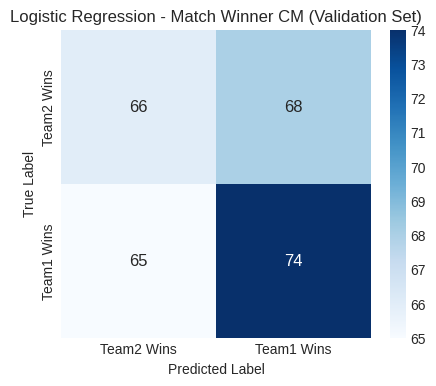

 Training and evaluating Random Forest for Match Winner Prediction...
  Random Forest - Accuracy: 0.5238, F1: 0.5231, ROC AUC: 0.5343


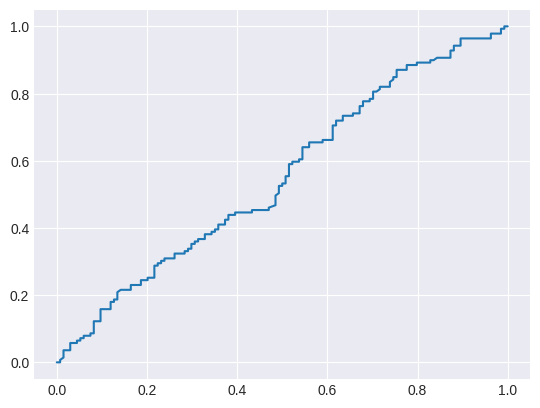

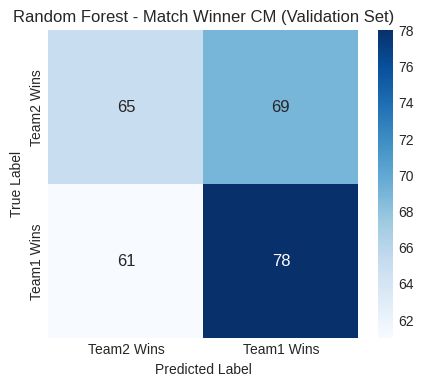

 Training and evaluating Gradient Boosting for Match Winner Prediction...
  Gradient Boosting - Accuracy: 0.5055, F1: 0.5005, ROC AUC: 0.5213


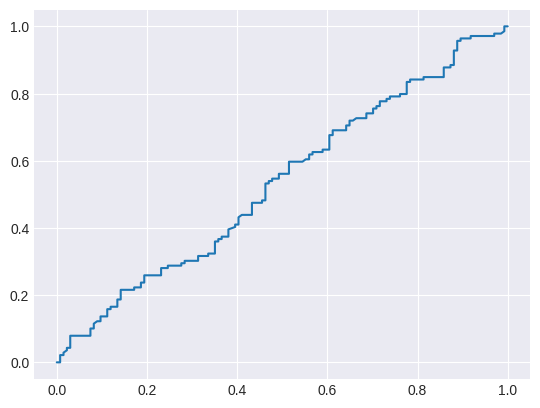

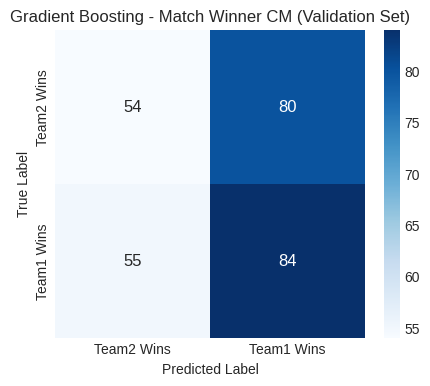

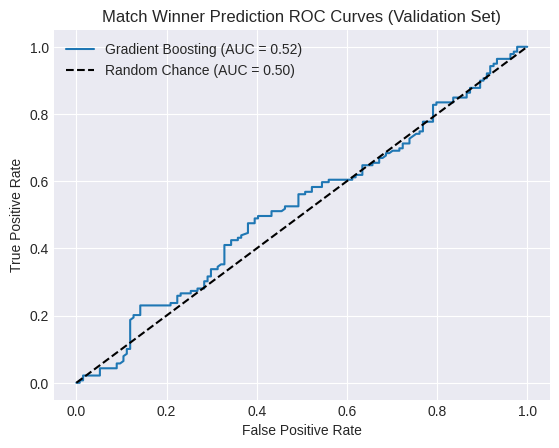


Best Match Winner Prediction Model (based on weighted F1): Random Forest with F1: 0.5231


In [13]:
# --- Evaluate Match Winner Prediction Models ---
print("\n--- Evaluating Match Winner Prediction Models ---")
best_match_model_name = None
best_match_f1 = -1

# Create figure for Match Winner ROC Curves (will be populated in the loop)
plt.figure(figsize=(10, 7)) # ROC Curve plot

for name, model in models.items():
    print(f" Training and evaluating {name} for Match Winner Prediction...")
    
    # Train the model using SCALED features
    model.fit(X_match_train, y_match_train)
    
    # Make predictions on the SCALED validation set
    y_pred = model.predict(X_match_val)
    # Get probabilities for the positive class (team1_win=1)
    try:
        y_pred_proba = model.predict_proba(X_match_val)[:, 1]
        roc_auc_calculable = True
    except AttributeError:
        print(f"  Warning: {name} does not have predict_proba. ROC AUC cannot be calculated.")
        y_pred_proba = y_pred
        roc_auc = np.nan
        roc_auc_calculable = False

    # Calculate metrics
    accuracy = accuracy_score(y_match_val, y_pred)
    precision = precision_score(y_match_val, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_match_val, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_match_val, y_pred, average='weighted', zero_division=0)
    if roc_auc_calculable:
        roc_auc = roc_auc_score(y_match_val, y_pred_proba)
        
    cm = confusion_matrix(y_match_val, y_pred)

    # Append results for the match winner prediction task
    results_list.append({
        'Model Type': 'Match Winner Prediction', 'Model Name': name, 'Accuracy': accuracy,
        'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'ROC AUC': roc_auc
    })

    # Correctly format ROC AUC conditionally
    roc_auc_str = f"{roc_auc:.4f}" if roc_auc_calculable else "N/A"
    print(f"  {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC AUC: {roc_auc_str}")

    # Plot Confusion Matrix for each model
    plt.figure(figsize=(5, 4)) # Separate figure for CM
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Team2 Wins', 'Team1 Wins'],
                yticklabels=['Team2 Wins', 'Team1 Wins'],
                annot_kws={"size": 12})
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{name} - Match Winner CM (Validation Set)')
    plt.show() # Show CM immediately

    # Add to combined ROC Curve plot if calculable
    if roc_auc_calculable:
        fpr, tpr, _ = roc_curve(y_match_val, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

     # Track best model based on F1 score
    current_f1 = f1 if not np.isnan(f1) else -1
    if current_f1 > best_match_f1:
        best_match_f1 = current_f1
        best_match_model_name = name

# Finalize Match Winner ROC Plot (ensure it's called after the loop)
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Match Winner Prediction ROC Curves (Validation Set)')
plt.legend()
plt.grid(True)
plt.show() # Show the combined ROC plot

print(f"\nBest Match Winner Prediction Model (based on weighted F1): {best_match_model_name} with F1: {best_match_f1:.4f}")

### Cell 14: Display Evaluation Summary

This cell consolidates and displays the performance metrics collected during the evaluation phase (Cells 12 and 13) for all tested models and tasks.
*   It converts the `results_list` (which now contains dictionaries of metrics for each model/task combination) into a pandas DataFrame called `evaluation_df`.
*   It then `display()`s this DataFrame, providing a clear, tabular overview of how each model performed on the validation set according to various metrics (Accuracy, Precision, Recall, F1 Score, ROC AUC). This helps in comparing models and justifying the selection of the "best" models.

In [14]:
# --- Display evaluation results in a DataFrame ---
evaluation_df = pd.DataFrame(results_list)
print("\n--- Model Evaluation Summary ---")
# Display with formatting for better readability in notebooks
display(evaluation_df.round(4))

# Optional: Print markdown format as well
# print("\nMarkdown Format Summary:")
# print(evaluation_df.to_markdown(index=False))


--- Model Evaluation Summary ---


,Model Type,Model Name,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Toss Prediction,Logistic Regression,0.5275,0.5428,0.5275,0.5327,0.4971
1,Toss Prediction,Random Forest,0.5531,0.5641,0.5531,0.5572,0.5499
2,Toss Prediction,Gradient Boosting,0.5971,0.5570,0.5971,0.5423,0.5976
3,Match Winner Prediction,Logistic Regression,0.5128,0.5126,0.5128,0.5127,0.5519
4,Match Winner Prediction,Random Forest,0.5238,0.5234,0.5238,0.5231,0.5343
5,Match Winner Prediction,Gradient Boosting,0.5055,0.5040,0.5055,0.5005,0.5213


### Cell 15: Retrain Best Models on Full Historical Data

This cell retrains the models identified as the best performers (based on validation F1-score) using the *entire* available historical dataset. This aims to create the most robust models possible for predicting future matches.
*   It retrieves the names of the best toss and match models stored in `best_toss_model_name` and `best_match_model_name`.
*   It creates *new* instances of these best model types (`final_toss_model`, `final_match_model`) using their original parameters.
*   **Toss Model Retraining:** Fits `final_toss_model` on the complete historical toss dataset (`X_toss`, `y_toss`).
*   **Match Model Retraining (Crucial Step):**
    *   Initializes a *new* `StandardScaler` (`scaler_final`).
    *   Fits this scaler on and transforms the numerical features of the *entire* historical match dataset (`X_match`). This scaled data is stored in `X_match_full_scaled`.
    *   Fits `final_match_model` on this `X_match_full_scaled` and the complete `y_match`.
*   Prints confirmation messages upon completion.
*   **Important:** `scaler_final` (fitted on the full historical data) is now ready to be used to scale the upcoming IPL 2025 schedule data before prediction.

In [15]:
# --- 5. Retrain Best Models on Full Historical Data ---
print("\n--- Retraining Best Models on Full Historical Data ---")

# Check if best models were identified
if best_toss_model_name is None or best_match_model_name is None:
     raise ValueError("Best models could not be identified from evaluation. Cannot proceed with retraining.")

# Get new instances of the best model types using the original definitions
# This ensures we don't modify the models used during evaluation loops
final_toss_model = models[best_toss_model_name].__class__(**models[best_toss_model_name].get_params())
final_match_model = models[best_match_model_name].__class__(**models[best_match_model_name].get_params())

print(f"Retraining {best_toss_model_name} for Toss Prediction on {len(X_toss)} samples...")
# Fit on the complete historical toss data (X_toss, y_toss)
final_toss_model.fit(X_toss, y_toss)
print("Toss model retrained.")

print(f"\nRetraining {best_match_model_name} for Match Winner Prediction on {len(X_match)} samples...")
# --- IMPORTANT: Scale the *entire* historical match feature set before retraining ---
# Use a NEW scaler instance or re-fit the existing one on the full data
scaler_final = StandardScaler()
X_match_full_scaled = X_match.copy()
# Fit AND transform the numerical features of the full dataset
X_match_full_scaled[match_features_numerical] = scaler_final.fit_transform(X_match_full_scaled[match_features_numerical])

# Fit the match model on the fully scaled historical data (X_match_full_scaled, y_match)
final_match_model.fit(X_match_full_scaled, y_match)
print("Match Winner model retrained using fully scaled data.")

# Keep the scaler used for the final model (scaler_final) for predicting on new data


--- Retraining Best Models on Full Historical Data ---
Retraining Random Forest for Toss Prediction on 1090 samples...
Toss model retrained.

Retraining Random Forest for Match Winner Prediction on 1090 samples...
Match Winner model retrained using fully scaled data.


### Cell 16: Prepare IPL 2025 Schedule Data for Prediction

This cell takes the raw IPL 2025 schedule data and processes it to match the format expected by the retrained prediction models.
*   Creates a copy of the `schedule_df`.
*   **Column Renaming:** Renames columns like 'Location', 'Home Team', 'Away Team', 'Match Number' to 'venue', 'team1', 'team2', 'match_number' for consistency with the historical data structure.
*   **Filtering:** Filters the schedule to include only matches 1 through 70 (typical league stage), dropping any playoff matches or rows with invalid match numbers.
*   **Date Conversion:** Converts the 'date' column to datetime objects.
*   **Encoding:** Applies the `LabelEncoder` objects stored in the `encoders` dictionary (fitted in Cell 8 on combined historical+schedule data) to the corresponding columns (`venue`, `team1`, `team2`) in the schedule data.
    *   Crucially, it handles **unseen values** (e.g., a new venue or team not present in the historical data used for fitting the encoder). Such values are encoded as -1, and a warning is printed. Matches with unseen values might yield unreliable predictions. Original team/venue names are kept for reporting.
*   **Merging Stats:** Merges the *overall historical* team batting and bowling averages (from `team_batting_avg`, `team_bowling_avg`) onto the schedule DataFrame based on `team1` and `team2`.
*   **NaN Filling (Stats):** Fills any potential NaNs in the merged statistical columns (e.g., if a new team has no historical stats) using the *global mean* of that feature calculated from the entire historical `matches_df`.
*   **Placeholder Columns:** Adds placeholder columns `toss_winner_encoded` and `toss_decision_encoded` initialized to -1. These will be filled with the *predicted* toss outcomes in the next step before predicting the match winner.
*   **Scaling:** Applies the `StandardScaler` (`scaler_final`, fitted on the full historical data in Cell 15) to *transform* the numerical features in the prepared schedule data. The result is stored in `schedule_pred_df_scaled`.
*   Displays the head of the relevant columns from both the unscaled (`schedule_pred_df`) and scaled (`schedule_pred_df_scaled`) schedule DataFrames for verification.

In [16]:
# --- 6. Prepare IPL 2025 Schedule Data for Prediction ---
print("\n--- Preparing IPL 2025 Schedule for Prediction ---")

schedule_pred_df = schedule_df.copy()

# Rename columns to match historical data structure for consistency
schedule_pred_df.rename(columns={
    'Date': 'date', # Assuming schedule has 'Date'
    'Location': 'venue', # Assuming schedule has 'Location'
    'Home Team': 'team1',
    'Away Team': 'team2',
    'Match Number': 'match_number' # Assuming schedule has 'Match Number'
}, inplace=True)

# Ensure 'match_number' exists and filter if necessary (e.g., only league stage)
if 'match_number' in schedule_pred_df.columns:
    schedule_pred_df['match_number'] = pd.to_numeric(schedule_pred_df['match_number'], errors='coerce')
    schedule_pred_df.dropna(subset=['match_number'], inplace=True) # Drop if match number is invalid
    schedule_pred_df['match_number'] = schedule_pred_df['match_number'].astype(int)
    # Filter for matches 1-70 (typical league stage)
    schedule_pred_df = schedule_pred_df[schedule_pred_df['match_number'] <= 70].reset_index(drop=True)
    print(f"Filtered schedule to {len(schedule_pred_df)} matches (<= 70).")
else:
    print("Warning: 'match_number' column not found in schedule. Using all rows.")
    schedule_pred_df['match_number'] = range(1, len(schedule_pred_df) + 1) # Assign sequential numbers


# Convert date, handle potential errors
if 'date' in schedule_pred_df.columns:
     # Try multiple formats if necessary
    try:
        schedule_pred_df['date'] = pd.to_datetime(schedule_pred_df['date'], format='%d/%m/%Y %H:%M', errors='coerce')
    except ValueError:
         schedule_pred_df['date'] = pd.to_datetime(schedule_pred_df['date'], errors='coerce') # Try auto-detection
    # Check if any dates failed to parse
    if schedule_pred_df['date'].isnull().any():
        print(f"Warning: {schedule_pred_df['date'].isnull().sum()} dates in schedule failed to parse.")
else:
    print("Warning: 'date' column not found in schedule.")
    schedule_pred_df['date'] = pd.NaT # Assign NaT if date column is missing

# --- Apply Encoding using fitted encoders ---
print("Applying encoding to schedule data...")
categorical_schedule_cols = ['venue', 'team1', 'team2']
for col in categorical_schedule_cols:
    if col in schedule_pred_df.columns and col in encoders:
        le = encoders[col]
        schedule_pred_df[f'{col}_original'] = schedule_pred_df[col] # Keep original names for reporting
        
        # Handle unseen values: transform known values, mark others as -1 (or another indicator)
        schedule_pred_df[f'{col}_encoded'] = schedule_pred_df[col].astype(str).apply(
            lambda s: le.transform([s])[0] if s in le.classes_ else -1
        )
        
        # Report unseen values
        unseen_mask = (schedule_pred_df[f'{col}_encoded'] == -1)
        if unseen_mask.any():
            unseen_values = schedule_pred_df.loc[unseen_mask, col].unique()
            print(f"Warning: Unseen values found in schedule column '{col}': {unseen_values}. Predictions for these matches might be unreliable or skipped.")
    elif col not in schedule_pred_df.columns:
         print(f"Warning: Column '{col}' not found in schedule_pred_df for encoding.")
         schedule_pred_df[f'{col}_encoded'] = -1 # Mark all as invalid if column missing
    elif col not in encoders:
         print(f"Warning: Encoder for column '{col}' not found. Skipping encoding for this column.")
         schedule_pred_df[f'{col}_encoded'] = -1 # Mark all as invalid if encoder missing


# --- Merge Overall Historical Stats ---
print("Merging historical team stats into schedule data...")
# Merge based on the original team names before potential encoding issues
schedule_pred_df = schedule_pred_df.merge(team_batting_avg[['batting_team', 'overall_avg_sr']],
                                          left_on='team1_original', right_on='batting_team', how='left')
schedule_pred_df.rename(columns={'overall_avg_sr': 'team1_overall_avg_sr'}, inplace=True)
schedule_pred_df.drop('batting_team', axis=1, errors='ignore', inplace=True) # Use errors='ignore'

schedule_pred_df = schedule_pred_df.merge(team_batting_avg[['batting_team', 'overall_avg_sr']],
                                          left_on='team2_original', right_on='batting_team', how='left')
schedule_pred_df.rename(columns={'overall_avg_sr': 'team2_overall_avg_sr'}, inplace=True)
schedule_pred_df.drop('batting_team', axis=1, errors='ignore', inplace=True)

schedule_pred_df = schedule_pred_df.merge(team_bowling_avg[['bowling_team', 'overall_avg_econ', 'overall_avg_wicket_rate']],
                                          left_on='team1_original', right_on='bowling_team', how='left')
schedule_pred_df.rename(columns={'overall_avg_econ': 'team1_overall_avg_econ', 'overall_avg_wicket_rate': 'team1_overall_avg_wicket_rate'}, inplace=True)
schedule_pred_df.drop('bowling_team', axis=1, errors='ignore', inplace=True)

schedule_pred_df = schedule_pred_df.merge(team_bowling_avg[['bowling_team', 'overall_avg_econ', 'overall_avg_wicket_rate']],
                                          left_on='team2_original', right_on='bowling_team', how='left')
schedule_pred_df.rename(columns={'overall_avg_econ': 'team2_overall_avg_econ', 'overall_avg_wicket_rate': 'team2_overall_avg_wicket_rate'}, inplace=True)
schedule_pred_df.drop('bowling_team', axis=1, errors='ignore', inplace=True)

# Fill NaNs in stats (e.g., if a 2025 team wasn't in historical data) - Use GLOBAL means calculated earlier
print("Filling potential NaNs in merged stats for schedule data...")
for col in match_features_numerical: # Use the list of numerical features
     if col in schedule_pred_df.columns:
        # Use the mean from the *historical* data (matches_df) for consistency
        # This assumes the overall historical average is a reasonable fill value
        global_mean = matches_df[col].mean()
        schedule_pred_df[col].fillna(global_mean, inplace=True)
        # print(f" Filled NaNs in schedule '{col}' with global mean: {global_mean:.2f}") # Optional print
     else:
        print(f"Warning: Numerical feature '{col}' not found in schedule_pred_df after merge. Filling with 0.")
        schedule_pred_df[col] = 0 # Add column and fill with 0 if completely missing


# Add placeholder columns for features needed for match prediction (toss outcome)
# These will be filled during the prediction loop
schedule_pred_df['toss_winner_encoded'] = -1 # Use -1 to indicate 'not yet predicted'
schedule_pred_df['toss_decision_encoded'] = -1

# --- Scale numerical features using the scaler fitted on the FULL historical data ---
print("Scaling numerical features in schedule data...")
schedule_pred_df_scaled = schedule_pred_df.copy()
# Ensure all numerical features expected by the model exist before scaling
missing_num_for_scaling = [f for f in match_features_numerical if f not in schedule_pred_df_scaled.columns]
if missing_num_for_scaling:
     raise ValueError(f"Missing numerical features required for scaling in schedule data: {missing_num_for_scaling}")

# Use scaler_final (fitted on full historical data) to transform the schedule data
schedule_pred_df_scaled[match_features_numerical] = scaler_final.transform(schedule_pred_df_scaled[match_features_numerical])

print("Schedule data prepared, encoded, stats merged, and scaled.")
display(schedule_pred_df[['match_number', 'venue_encoded', 'team1_encoded', 'team2_encoded'] + match_features_numerical].head())
display(schedule_pred_df_scaled[['match_number', 'venue_encoded', 'team1_encoded', 'team2_encoded'] + match_features_numerical].head())


--- Preparing IPL 2025 Schedule for Prediction ---
Filtered schedule to 70 matches (<= 70).
Applying encoding to schedule data...
Merging historical team stats into schedule data...
Filling potential NaNs in merged stats for schedule data...
Scaling numerical features in schedule data...
Schedule data prepared, encoded, stats merged, and scaled.


,match_number,venue_encoded,team1_encoded,team2_encoded,team1_overall_avg_sr,team2_overall_avg_sr,team1_overall_avg_econ,team2_overall_avg_econ,team1_overall_avg_wicket_rate,team2_overall_avg_wicket_rate
0,1,17,6,14,133.262181,161.166117,7.906011,9.394781,20.261612,20.465909
1,2,46,15,11,133.090693,132.409877,8.040613,7.977149,20.220670,20.698512
2,3,29,0,8,134.826010,134.160384,7.812220,7.864656,19.295071,19.802011
3,4,13,2,7,131.831024,139.074074,8.040814,8.513203,19.987316,19.795455
4,5,35,4,10,141.190390,134.332915,8.460668,8.219848,17.788591,20.695960


,match_number,venue_encoded,team1_encoded,team2_encoded,team1_overall_avg_sr,team2_overall_avg_sr,team1_overall_avg_econ,team2_overall_avg_econ,team1_overall_avg_wicket_rate,team2_overall_avg_wicket_rate
0,1,17,6,14,-0.010039,7.146119,-0.396444,6.326684,0.103324,0.360569
1,2,46,15,11,-0.050833,-0.208873,0.176417,-0.082611,0.052335,0.653723
2,3,29,0,8,0.361974,0.238854,-0.795612,-0.591204,-1.100413,-0.476152
3,4,13,2,7,-0.350490,1.495630,0.177269,2.340959,-0.238286,-0.484415
4,5,35,4,10,1.875968,0.282982,1.964145,1.014662,-2.976593,0.650507


### Cell 17: Generate Final Predictions for IPL 2025

This cell performs the final predictions for each of the 70 IPL 2025 matches using the retrained models and the prepared schedule data.
*   Initializes an empty list `final_predictions`.
*   **Iterates through Schedule:** Loops through each match (row) in the prepared schedule DataFrames (`schedule_pred_df` for unscaled, `schedule_pred_df_scaled` for scaled).
*   **Toss Winner Prediction:**
    *   Selects the required features (`final_toss_pred_features`) from the *unscaled* schedule row.
    *   Uses the `final_toss_model` to predict whether team1 wins the toss (1) or not (0).
    *   Translates the prediction (0 or 1) back into the actual team name (`predicted_toss_winner_team`).
    *   Encodes this predicted team name back into its numerical representation (`predicted_toss_winner_encoded`) using the `toss_winner` encoder (handling potential errors if the predicted name wasn't seen during encoding). It defaults to -1 if encoding fails or if input features contained unseen values (-1).
*   **Toss Decision (Assumption):**
    *   Assumes the toss winner will choose to 'field' (a common IPL trend, though a simplification).
    *   Encodes 'field' into its numerical representation (`predicted_toss_decision_encoded`) using the `toss_decision` encoder (defaults to -1 if encoding fails).
*   **Match Winner Prediction:**
    *   Prepares the input features (`X_match_live`) using the *scaled* schedule row data.
    *   **Crucially, updates** this input data with the `predicted_toss_winner_encoded` and `predicted_toss_decision_encoded` obtained above.
    *   Uses the `final_match_model` to predict the match outcome (1 for team1 win, 0 for team2 win).
    *   Also uses `.predict_proba()` to get the probabilities for each outcome.
    *   Determines the `predicted_match_winner` name based on the prediction (0 or 1).
    *   Extracts the `win_probability` corresponding to the predicted winner.
    *   Handles cases where input features were invalid (-1), setting the winner to "Unknown" and probability to 0.0.
*   **Store Results:** Appends a dictionary containing the match details, predicted toss winner, predicted match winner, and winner probability to the `final_predictions` list.
*   **Final DataFrame:** Converts the `final_predictions` list into the `final_predictions_df`.
*   Displays the `final_predictions_df` containing the predictions for all 70 matches.

In [17]:
# --- 7. Final Prediction for IPL 2025 ---
print("\n--- Generating Final Predictions for IPL 2025 ---")
final_predictions = []

# Define features used by the FINAL models (ensure these match definition in Cell 9)
final_toss_pred_features = toss_features
final_match_pred_features = match_features

# Iterate through each scheduled match
for index, match_row_unscaled in schedule_pred_df.iterrows():
    # Get the corresponding row with scaled numerical features
    match_row_scaled = schedule_pred_df_scaled.loc[index]

    match_number = match_row_unscaled['match_number']
    team1_name = match_row_unscaled['team1_original']
    team2_name = match_row_unscaled['team2_original']
    venue_name = match_row_unscaled['venue_original']
    match_date = match_row_unscaled['date']

    # --- Predict Toss Winner ---
    predicted_toss_winner_team = "Unknown (Invalid Input)"
    predicted_toss_winner_encoded = -1 # Default to invalid

    # Prepare features for toss prediction (use unscaled encoded values)
    X_toss_live = pd.DataFrame([match_row_unscaled])[final_toss_pred_features]

    # Check if any input feature for toss prediction is invalid (-1)
    if not (X_toss_live == -1).any().any():
        try:
            toss_pred_encoded = final_toss_model.predict(X_toss_live)[0] # Predict 0 or 1
            predicted_toss_winner_team = team1_name if toss_pred_encoded == 1 else team2_name

            # Try to encode the predicted winner name back using the 'toss_winner' encoder
            if 'toss_winner' in encoders:
                le_toss_winner = encoders['toss_winner']
                if predicted_toss_winner_team in le_toss_winner.classes_:
                    predicted_toss_winner_encoded = le_toss_winner.transform([predicted_toss_winner_team])[0]
                else:
                    print(f"Warning Match {match_number}: Predicted toss winner '{predicted_toss_winner_team}' is not in the encoder's known classes. Setting encoded toss winner to -1.")
                    predicted_toss_winner_encoded = -1
            else:
                 print(f"Warning Match {match_number}: 'toss_winner' encoder not found. Cannot set encoded toss winner.")
                 predicted_toss_winner_encoded = -1

        except Exception as e:
            print(f"Error predicting toss for Match {match_number}: {e}")
            # Keep predicted_toss_winner_team as "Unknown..." and encoded as -1
    else:
        print(f"Skipping Toss Prediction for Match {match_number} due to unseen categorical values in input features.")
        # Keep predicted_toss_winner_team as "Unknown..." and encoded as -1


    # --- Predict Toss Decision (Simplification: Assume 'field' if possible) ---
    predicted_toss_decision = 'field' # Simple assumption
    predicted_toss_decision_encoded = -1 # Default to invalid

    if 'toss_decision' in encoders:
        le_toss_decision = encoders['toss_decision']
        if predicted_toss_decision in le_toss_decision.classes_:
            predicted_toss_decision_encoded = le_toss_decision.transform([predicted_toss_decision])[0]
        else:
            print(f"Warning Match {match_number}: Assumed toss decision '{predicted_toss_decision}' is not in the encoder's known classes. Setting encoded toss decision to -1.")
            # Keep encoded as -1
    else:
        print(f"Warning Match {match_number}: 'toss_decision' encoder not found. Cannot set encoded toss decision.")
        # Keep encoded as -1

    # --- Prepare Input for Match Winner Prediction ---
    # Start with the SCALED data row
    match_data_for_win_pred = match_row_scaled.to_dict()
    # Overwrite the placeholder toss info with the predicted (or invalid -1) values
    match_data_for_win_pred['toss_winner_encoded'] = predicted_toss_winner_encoded
    match_data_for_win_pred['toss_decision_encoded'] = predicted_toss_decision_encoded

    # Create DataFrame for prediction (ensure columns are in the correct order)
    X_match_live = pd.DataFrame([match_data_for_win_pred])[final_match_pred_features]

    # --- Predict Match Winner ---
    predicted_match_winner = "Unknown (Invalid Input)"
    win_probability = 0.0

    # Check if any input feature for match prediction is invalid (-1)
    if not (X_match_live == -1).any().any():
        try:
            match_win_pred_encoded = final_match_model.predict(X_match_live)[0] # Predict 0 or 1
            match_win_prob = final_match_model.predict_proba(X_match_live)[0] # Probabilities [P(class 0), P(class 1)]

            predicted_match_winner = team1_name if match_win_pred_encoded == 1 else team2_name
            # Probability corresponds to the predicted class
            win_probability = match_win_prob[1] if match_win_pred_encoded == 1 else match_win_prob[0]

        except Exception as e:
            print(f"Error predicting match winner for Match {match_number}: {e}")
            # Keep defaults "Unknown..." and 0.0 probability
    else:
         print(f"Skipping Match Winner Prediction for Match {match_number} due to invalid input features (unseen values or failed toss prediction).")
         # Keep defaults "Unknown..." and 0.0 probability


    # --- Store results ---
    final_predictions.append({
        'Match Number': match_number,
        'Date': match_date.strftime('%Y-%m-%d %H:%M') if pd.notnull(match_date) else 'Invalid Date',
        'Venue': venue_name,
        'Team 1': team1_name,
        'Team 2': team2_name,
        'Predicted Toss Winner': predicted_toss_winner_team,
        'Predicted Match Winner': predicted_match_winner,
        'Match Winner Probability': f"{win_probability:.3f}" # More precision for probability
    })

# Convert final predictions list to DataFrame
final_predictions_df = pd.DataFrame(final_predictions)

print("\n--- Final IPL 2025 Predictions (Matches 1-70) ---")
display(final_predictions_df)

# Optional: Print markdown format as well
# print("\nMarkdown Format Predictions:")
# print(final_predictions_df.to_markdown(index=False))


--- Generating Final Predictions for IPL 2025 ---

--- Final IPL 2025 Predictions (Matches 1-70) ---


,Match Number,Date,Venue,Team 1,Team 2,Predicted Toss Winner,Predicted Match Winner,Match Winner Probability
0,1,2025-03-22 14:00,Eden Gardens,Kolkata Knight Riders,Royal Challengers Bengaluru,Royal Challengers Bengaluru,Kolkata Knight Riders,0.599
1,2,2025-03-23 10:00,Rajiv Gandhi International Stadium,Sunrisers Hyderabad,Rajasthan Royals,Rajasthan Royals,Sunrisers Hyderabad,0.537
2,3,2025-03-23 14:00,MA Chidambaram Stadium,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,Mumbai Indians,0.510
3,4,2025-03-24 14:00,Dr YS Rajasekhara Reddy ACA-VDCA Cricket Stadium,Delhi Capitals,Lucknow Super Giants,Lucknow Super Giants,Delhi Capitals,0.550
4,5,2025-03-25 14:00,Narendra Modi Stadium,Gujarat Titans,Punjab Kings,Punjab Kings,Gujarat Titans,0.501
...,...,...,...,...,...,...,...,...
65,66,2025-05-15 14:00,Wankhede Stadium,Mumbai Indians,Delhi Capitals,Delhi Capitals,Mumbai Indians,0.572
66,67,2025-05-16 14:00,Sawai Mansingh Stadium,Rajasthan Royals,Punjab Kings,Rajasthan Royals,Rajasthan Royals,0.580
67,68,2025-05-17 14:00,M Chinnaswamy Stadium,Royal Challengers Bengaluru,Kolkata Knight Riders,Kolkata Knight Riders,Kolkata Knight Riders,0.611
68,69,2025-05-18 10:00,Narendra Modi Stadium,Gujarat Titans,Chennai Super Kings,Chennai Super Kings,Gujarat Titans,0.546


### Cell 18: Save Predictions to CSV

This cell saves the generated predictions for the IPL 2025 matches into a CSV file.
*   Uses the `.to_csv()` method on the `final_predictions_df`.
*   Specifies the output file name using the `OUTPUT_PREDICTIONS_CSV` variable (`ipl_2025_predictions.csv`).
*   Sets `index=False` to prevent writing the DataFrame index to the file.
*   Includes basic error handling and prints a confirmation message upon successful saving.

In [18]:
# --- Save Final Predictions to CSV ---
print(f"\n--- Saving Predictions to CSV: {OUTPUT_PREDICTIONS_CSV} ---")
try:
    final_predictions_df.to_csv(OUTPUT_PREDICTIONS_CSV, index=False, encoding='utf-8')
    print(f"Predictions successfully saved to {OUTPUT_PREDICTIONS_CSV}")
except Exception as e:
    print(f"Error saving predictions to CSV: {e}")


--- Saving Predictions to CSV: ipl_2025_predictions.csv ---
Predictions successfully saved to ipl_2025_predictions.csv


### Cell 19: Generate Enhanced Report File (`report_enhanced.md`)

This cell constructs the final Markdown report (`report_enhanced.md`) incorporating data storytelling elements for each match prediction.
*   **Helper Functions:** Defines internal helper functions (`get_venue_stats`, `get_toss_stats`, `get_h2h_stats`) to query the historical `matches_df` and retrieve relevant statistics (venue win percentages, team toss trends, head-to-head records, recent form) based on the teams and venue for a given match.
*   **Report Initialization:** Starts building the `report_content` string with the main title, generation timestamp, and a detailed introduction explaining the project methodology, data sources, feature engineering steps, model evaluation process, best models selected, and limitations.
*   **Evaluation Summary:** Appends the model evaluation summary table (from `evaluation_df`) in Markdown format to the report.
*   **Match-by-Match Loop:** Iterates through the `final_predictions_df`. For each match:
    *   Adds a Markdown section header for the match.
    *   Includes the date and venue.
    *   **Calls helper functions** to fetch and format historical insights (Venue Trends, Toss Analysis for both teams, Head-to-Head records, optional historical performance metrics like SR/Econ). These insights provide context for the prediction.
    *   Adds the **Model Predictions** section, listing the predicted toss winner, the *assumed* toss decision, the predicted match winner (bolded), and the associated win probability.
    *   Includes a **placeholder for a Code Snippet** for Match 1 only, as requested by the project instructions, explaining its purpose and suggesting manual insertion of a relevant snippet.
    *   Adds a separator (`---`) before the next match.
*   **File Writing:** Writes the complete `report_content` string to the file specified by `OUTPUT_REPORT_FILE` (`report_enhanced.md`), using UTF-8 encoding.
*   Prints confirmation or error messages.
*   **This cell embodies the data storytelling requirement by combining historical analysis with model predictions for each individual match.**

In [19]:
# --- 8. Generate Enhanced report.md (Replaces existing Cell 31) ---
print(f"\n--- Generating Enhanced Report: {OUTPUT_REPORT_FILE} ---")

# --- Helper Functions for Historical Insights ---
# (Ensure 'matches_df' is the preprocessed historical data with standardized names)

def get_venue_stats(venue, matches_hist_df):
    """Calculates win percentage batting second at a venue."""
    venue_matches = matches_hist_df[matches_hist_df['venue'] == venue].copy()
    total_matches = len(venue_matches)
    if total_matches == 0:
        return "No historical matches found at this venue."

    # Calculate wins batting second more directly
    venue_matches['bat_second_win'] = venue_matches.apply(
        lambda row: 1 if (row['toss_decision'] == 'field' and row['winner'] == row['toss_winner']) or \
                         (row['toss_decision'] == 'bat' and row['winner'] != row['toss_winner']) else 0, axis=1
    )
    bat_second_wins = venue_matches['bat_second_win'].sum()

    win_pct_bat_second = (bat_second_wins / total_matches) * 100 if total_matches > 0 else 0

    # Avg 1st innings score (Requires merging with deliveries/inning scores - simplified here)
    # avg_first_innings = "Avg score calculation requires deliveries data merge (not implemented here)."

    return (f"Teams batting second have won **{win_pct_bat_second:.1f}%** of the {total_matches} matches played here. "
            # f"{avg_first_innings}"
           )


def get_toss_stats(venue, team, matches_hist_df):
    """Calculates toss win percentages and decision preferences."""
    # Team's overall toss win %
    team_matches_total = matches_hist_df[(matches_hist_df['team1'] == team) | (matches_hist_df['team2'] == team)]
    team_toss_wins_total = team_matches_total[team_matches_total['toss_winner'] == team]
    overall_toss_pct = (len(team_toss_wins_total) / len(team_matches_total) * 100) if len(team_matches_total) > 0 else 0

    # At this venue
    venue_matches = matches_hist_df[matches_hist_df['venue'] == venue].copy()
    total_venue_matches = len(venue_matches)

    if total_venue_matches == 0:
        return f"{team} has an overall toss win rate of **{overall_toss_pct:.1f}%**. No venue-specific toss data."

    # Team's toss win % at venue
    team_toss_wins_venue = venue_matches[venue_matches['toss_winner'] == team]
    venue_toss_pct = (len(team_toss_wins_venue) / total_venue_matches * 100) if total_venue_matches > 0 else 0 # Use total venue matches for venue %

    # Toss decision preference at venue (when THIS team wins toss)
    if len(team_toss_wins_venue) > 0:
        field_chosen_pct = (len(team_toss_wins_venue[team_toss_wins_venue['toss_decision'] == 'field']) / len(team_toss_wins_venue) * 100)
        decision_pref = f"When {team} wins the toss here, they choose to **field {field_chosen_pct:.1f}%** of the time. "
    else:
        decision_pref = f"{team} hasn't won a toss at this venue in the historical data. "

    # Toss win -> Match win % at venue (Overall)
    toss_winners_match_winners = venue_matches[venue_matches['toss_winner'] == venue_matches['winner']]
    toss_win_match_win_pct = (len(toss_winners_match_winners) / total_venue_matches * 100) if total_venue_matches > 0 else 0

    return (f"{team} wins the toss in **{venue_toss_pct:.1f}%** of matches at this venue (Overall toss win: {overall_toss_pct:.1f}%). "
            f"{decision_pref}"
            f"Overall at this venue, the team winning the toss wins the match **{toss_win_match_win_pct:.1f}%** of the time.")


def get_h2h_stats(team1, team2, venue, matches_hist_df):
    """Calculates Head-to-Head stats."""
    h2h_matches = matches_hist_df[((matches_hist_df['team1'] == team1) & (matches_hist_df['team2'] == team2)) |
                                ((matches_hist_df['team1'] == team2) & (matches_hist_df['team2'] == team1))].copy()
    total_h2h = len(h2h_matches)

    if total_h2h == 0:
        return "No historical head-to-head matches found between these teams."

    team1_wins = len(h2h_matches[h2h_matches['winner'] == team1])
    team2_wins = len(h2h_matches[h2h_matches['winner'] == team2])

    # Venue H2H
    venue_h2h_matches = h2h_matches[h2h_matches['venue'] == venue]
    venue_h2h_total = len(venue_h2h_matches)
    venue_team1_wins = len(venue_h2h_matches[venue_h2h_matches['winner'] == team1])
    venue_team2_wins = len(venue_h2h_matches[venue_h2h_matches['winner'] == team2])

    # Recent H2H (e.g., last 5)
    h2h_matches.sort_values('date', ascending=False, inplace=True)
    recent_matches = h2h_matches.head(5)
    recent_team1_wins = len(recent_matches[recent_matches['winner'] == team1])
    recent_team2_wins = len(recent_matches[recent_matches['winner'] == team2])

    h2h_text = f"Overall H2H: {team1} **{team1_wins}** - **{team2_wins}** {team2} (Total: {total_h2h}). "
    if venue_h2h_total > 0:
        h2h_text += f"At this venue: {team1} **{venue_team1_wins}** - **{venue_team2_wins}** {team2}. "
    else:
        h2h_text += "They haven't played each other at this venue historically. "

    if len(recent_matches) > 0:
         h2h_text += f"In their last {len(recent_matches)} encounters: {team1} **{recent_team1_wins}** - **{recent_team2_wins}** {team2}."
    else:
         h2h_text += "No recent encounters found."


    return h2h_text


# --- Report Content Generation ---
report_content = f"# IPL 2025 Toss & Match Winner Predictions (Enhanced)\n\n"
report_content += f"*Report Generated on: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')} UTC*\n\n" # Specify UTC if applicable

report_content += "## Introduction\n"
report_content += ("This report presents match-by-match predictions for the initial league stage (up to Match 70) of the IPL 2025 season, based on the provided schedule. "
                   "The predictions leverage machine learning models trained on historical IPL data (`matches.csv` and `deliveries.csv`).\n\n"
                   "Key steps in the process included:\n"
                   "- Loading and cleaning historical match and delivery data.\n"
                   "- Standardizing team names across datasets.\n"
                   "- Engineering features, including overall team batting strike rates and bowling economy/wicket rates derived from delivery data.\n"
                   "- Encoding categorical features (like venue, teams) consistently across historical and future schedule data.\n"
                   "- Evaluating several classification models (Logistic Regression, Random Forest, Gradient Boosting) for both toss and match winner prediction using a train-validation split.\n"
                   "- Selecting the best performing models based on the weighted F1-score on the validation set.\n"
                   f"- The best model for **Toss Prediction** was: **{best_toss_model_name}** (Validation F1: {best_toss_f1:.4f})\n"
                   f"- The best model for **Match Winner Prediction** was: **{best_match_model_name}** (Validation F1: {best_match_f1:.4f})\n"
                   "- Retraining these selected models on the entire historical dataset.\n"
                   "- Preparing the IPL 2025 schedule data (encoding, merging stats, scaling numerical features using the scaler fitted on historical data).\n"
                   "- Generating predictions for each match, including toss winner, match winner, and the winner's probability.\n\n"
                   "**Note:** Predictions rely on historical averages and patterns. Actual outcomes can be influenced by numerous real-time factors like player form, injuries, specific pitch conditions on the day, and strategic decisions not captured by this model. Unseen values (e.g., new venues or teams not in historical data) are handled, but predictions involving them may be less reliable.\n\n")

report_content += "## Model Evaluation Summary (Validation Set)\n"
# Ensure evaluation_df exists and has the expected columns before converting
if 'evaluation_df' in locals() and isinstance(evaluation_df, pd.DataFrame):
    report_content += evaluation_df.round(4).to_markdown(index=False) + "\n\n"
else:
    report_content += "Model evaluation summary data is not available.\n\n"

report_content += "---\n\n"

report_content += "## IPL 2025 Match Predictions (League Stage)\n\n"

# Loop through final predictions
for index, pred in final_predictions_df.iterrows():
    match_num = pred['Match Number']
    team1 = pred['Team 1']
    team2 = pred['Team 2']
    venue = pred['Venue']
    date_str_pred = pred['Date'] # Already formatted in prediction df

    report_content += f"### Match {match_num}: {team1} vs {team2}\n"
    report_content += f"**Date:** {date_str_pred} UTC\n" # Specify timezone if known
    report_content += f"**Venue:** {venue}\n\n"

    report_content += f"**Insights from Historical Data:**\n"
    try:
        # Get venue stats
        venue_insight = get_venue_stats(venue, matches_df)
        report_content += f"- **Venue Trends:** {venue_insight}\n"

        # Get Toss stats for Team 1
        toss_insight1 = get_toss_stats(venue, team1, matches_df)
        report_content += f"- **Toss Analysis ({team1}):** {toss_insight1}\n"

         # Get Toss stats for Team 2
        toss_insight2 = get_toss_stats(venue, team2, matches_df)
        report_content += f"- **Toss Analysis ({team2}):** {toss_insight2}\n"

        # Get H2H stats
        h2h_insight = get_h2h_stats(team1, team2, venue, matches_df)
        report_content += f"- **Head-to-Head:** {h2h_insight}\n"

        # Add comparison of historical averages (optional, but good)
        # Fetching pre-calculated averages is more efficient, but we can use team_batting_avg/team_bowling_avg DFs
        t1_sr = team_batting_avg.loc[team_batting_avg['batting_team'] == team1, 'overall_avg_sr'].values[0] if team1 in team_batting_avg['batting_team'].values else 'N/A'
        t2_sr = team_batting_avg.loc[team_batting_avg['batting_team'] == team2, 'overall_avg_sr'].values[0] if team2 in team_batting_avg['batting_team'].values else 'N/A'
        t1_econ = team_bowling_avg.loc[team_bowling_avg['bowling_team'] == team1, 'overall_avg_econ'].values[0] if team1 in team_bowling_avg['bowling_team'].values else 'N/A'
        t2_econ = team_bowling_avg.loc[team_bowling_avg['bowling_team'] == team2, 'overall_avg_econ'].values[0] if team2 in team_bowling_avg['bowling_team'].values else 'N/A'

        report_content += "- **Historical Performance Metrics:**\n"
        if t1_sr != 'N/A' and t2_sr != 'N/A':
             report_content += f"  - Avg Batting SR: {team1} ({t1_sr:.1f}) vs {team2} ({t2_sr:.1f})\n"
        if t1_econ != 'N/A' and t2_econ != 'N/A':
             report_content += f"  - Avg Bowling Econ: {team1} ({t1_econ:.2f}) vs {team2} ({t2_econ:.2f})\n"

    except Exception as e:
        report_content += f"- *Error retrieving historical insights for this match: {e}*\n"
    report_content += "\n"

    report_content += f"**Model Predictions:**\n"
    report_content += f"- **Predicted Toss Winner:** {pred['Predicted Toss Winner']}\n"
    report_content += f"- **Assumed Toss Decision:** field (Input for Match Prediction Model)\n" # Clarify assumption
    report_content += f"- **Predicted Match Winner:** **{pred['Predicted Match Winner']}**\n"
    report_content += f"- **Winner Probability:** {pred['Match Winner Probability']}\n\n"

    # Add Code Snippet placeholder - Explain how to add manually for one example
    if match_num == 1: # Only add the placeholder explanation once
        report_content += "**Code Snippet Insight (Example - Add Manually for a Representative Match):**\n"
        report_content += "*(This section is intended to show a small piece of the prediction logic for transparency. Below is a conceptual example of how Match 1's winner might be derived in the code. Add your actual relevant snippet here if desired.)*\n"
        report_content += "```python\n"
        report_content += "# Conceptual Snippet for Match 1 Winner Prediction\n"
        report_content += "# match_data_live_scaled = schedule_pred_df_scaled.iloc[0]\n"
        report_content += "# # ... (add predicted toss info to match_data_live_scaled) ...\n"
        report_content += "# X_live = pd.DataFrame([match_data_live_scaled])[final_match_pred_features]\n"
        report_content += "# match_win_pred_encoded = final_match_model.predict(X_live)[0]\n"
        report_content += "# match_win_prob = final_match_model.predict_proba(X_live)[0]\n"
        report_content += "# predicted_winner = team1 if match_win_pred_encoded == 1 else team2\n"
        report_content += "# probability = match_win_prob[1] if match_win_pred_encoded == 1 else match_win_prob[0]\n"
        report_content += "```\n\n"


    report_content += "---\n\n"

# --- Write Report File ---
try:
    with open(OUTPUT_REPORT_FILE, 'w', encoding='utf-8') as f:
        f.write(report_content)
    print(f"Report successfully generated: {OUTPUT_REPORT_FILE}")
except Exception as e:
    print(f"Error writing report file: {e}")

# --- Optional: Display the generated report content in the notebook ---
# from IPython.display import display, Markdown
# print(f"\n--- Displaying Generated Report ({OUTPUT_REPORT_FILE}) ---")
# display(Markdown(report_content))


--- Generating Enhanced Report: report_enhanced.md ---
Report successfully generated: report_enhanced.md


### Cell 20: Display Generated Report in Notebook

This cell provides a convenient way to view the generated Markdown report directly within the Jupyter Notebook output, without needing to open the `.md` file separately.
*   It checks if the `OUTPUT_REPORT_FILE` exists.
*   If it exists, it reads the entire content of the Markdown file.
*   It then uses `IPython.display.Markdown` to interpret the read content as Markdown and `display()` to render it in the cell's output area.
*   Includes error handling for file reading/display issues.

In [20]:
# --- 9. Display Generated Markdown Report ---
from IPython.display import display, Markdown
import os

print(f"\n--- Loading and Displaying Report from {OUTPUT_REPORT_FILE} ---")

# Check if the report file exists
if os.path.exists(OUTPUT_REPORT_FILE):
    try:
        # Read the content of the Markdown file
        with open(OUTPUT_REPORT_FILE, 'r', encoding='utf-8') as f:
            report_md_content = f.read()
        
        # Display the content as Markdown in the notebook output
        print("Report content loaded. Displaying below:")
        display(Markdown(report_md_content))
        
    except Exception as e:
        print(f"An error occurred while reading or displaying the report file: {e}")
else:
    print(f"Error: The report file '{OUTPUT_REPORT_FILE}' was not found. Please ensure the previous cell executed successfully.")


--- Loading and Displaying Report from report_enhanced.md ---
Report content loaded. Displaying below:


# IPL 2025 Toss & Match Winner Predictions (Enhanced)

*Report Generated on: 2025-03-27 19:59:51 UTC*

## Introduction
This report presents match-by-match predictions for the initial league stage (up to Match 70) of the IPL 2025 season, based on the provided schedule. The predictions leverage machine learning models trained on historical IPL data (`matches.csv` and `deliveries.csv`).

Key steps in the process included:
- Loading and cleaning historical match and delivery data.
- Standardizing team names across datasets.
- Engineering features, including overall team batting strike rates and bowling economy/wicket rates derived from delivery data.
- Encoding categorical features (like venue, teams) consistently across historical and future schedule data.
- Evaluating several classification models (Logistic Regression, Random Forest, Gradient Boosting) for both toss and match winner prediction using a train-validation split.
- Selecting the best performing models based on the weighted F1-score on the validation set.
- The best model for **Toss Prediction** was: **Random Forest** (Validation F1: 0.5572)
- The best model for **Match Winner Prediction** was: **Random Forest** (Validation F1: 0.5231)
- Retraining these selected models on the entire historical dataset.
- Preparing the IPL 2025 schedule data (encoding, merging stats, scaling numerical features using the scaler fitted on historical data).
- Generating predictions for each match, including toss winner, match winner, and the winner's probability.

**Note:** Predictions rely on historical averages and patterns. Actual outcomes can be influenced by numerous real-time factors like player form, injuries, specific pitch conditions on the day, and strategic decisions not captured by this model. Unseen values (e.g., new venues or teams not in historical data) are handled, but predictions involving them may be less reliable.

## Model Evaluation Summary (Validation Set)
| Model Type              | Model Name          |   Accuracy |   Precision |   Recall |   F1 Score |   ROC AUC |
|:------------------------|:--------------------|-----------:|------------:|---------:|-----------:|----------:|
| Toss Prediction         | Logistic Regression |     0.5275 |      0.5428 |   0.5275 |     0.5327 |    0.4971 |
| Toss Prediction         | Random Forest       |     0.5531 |      0.5641 |   0.5531 |     0.5572 |    0.5499 |
| Toss Prediction         | Gradient Boosting   |     0.5971 |      0.557  |   0.5971 |     0.5423 |    0.5976 |
| Match Winner Prediction | Logistic Regression |     0.5128 |      0.5126 |   0.5128 |     0.5127 |    0.5519 |
| Match Winner Prediction | Random Forest       |     0.5238 |      0.5234 |   0.5238 |     0.5231 |    0.5343 |
| Match Winner Prediction | Gradient Boosting   |     0.5055 |      0.504  |   0.5055 |     0.5005 |    0.5213 |

---

## IPL 2025 Match Predictions (League Stage)

### Match 1: Kolkata Knight Riders vs Royal Challengers Bengaluru
**Date:** 2025-03-22 14:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **2** - **0** Royal Challengers Bengaluru (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Kolkata Knight Riders **2** - **0** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Royal Challengers Bengaluru
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.599

**Code Snippet Insight (Example - Add Manually for a Representative Match):**
*(This section is intended to show a small piece of the prediction logic for transparency. Below is a conceptual example of how Match 1's winner might be derived in the code. Add your actual relevant snippet here if desired.)*
```python
# Conceptual Snippet for Match 1 Winner Prediction
# match_data_live_scaled = schedule_pred_df_scaled.iloc[0]
# # ... (add predicted toss info to match_data_live_scaled) ...
# X_live = pd.DataFrame([match_data_live_scaled])[final_match_pred_features]
# match_win_pred_encoded = final_match_model.predict(X_live)[0]
# match_win_prob = final_match_model.predict_proba(X_live)[0]
# predicted_winner = team1 if match_win_pred_encoded == 1 else team2
# probability = match_win_prob[1] if match_win_pred_encoded == 1 else match_win_prob[0]
```

---

### Match 2: Sunrisers Hyderabad vs Rajasthan Royals
**Date:** 2025-03-23 10:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **6.7%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 0.0%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **11** - **9** Rajasthan Royals (Total: 20). At this venue: Sunrisers Hyderabad **2** - **0** Rajasthan Royals. In their last 5 encounters: Sunrisers Hyderabad **3** - **2** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.537

---

### Match 3: Chennai Super Kings vs Mumbai Indians
**Date:** 2025-03-23 14:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **0.0%** of matches at this venue (Overall toss win: 54.8%). Mumbai Indians hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **17** - **20** Mumbai Indians (Total: 37). At this venue: Chennai Super Kings **0** - **2** Mumbai Indians. In their last 5 encounters: Chennai Super Kings **4** - **1** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Chennai Super Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.510

---

### Match 4: Delhi Capitals vs Lucknow Super Giants
**Date:** 2025-03-24 14:00 UTC
**Venue:** Dr YS Rajasekhara Reddy ACA-VDCA Cricket Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals has an overall toss win rate of **51.6%**. No venue-specific toss data.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Delhi Capitals **2** - **3** Lucknow Super Giants (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Delhi Capitals **2** - **3** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Lucknow Super Giants
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Delhi Capitals**
- **Winner Probability:** 0.550

---

### Match 5: Gujarat Titans vs Punjab Kings
**Date:** 2025-03-25 14:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Punjab Kings):** Punjab Kings has an overall toss win rate of **44.3%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **3** - **2** Punjab Kings (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Gujarat Titans **3** - **2** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Punjab Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.501

---

### Match 6: Rajasthan Royals vs Kolkata Knight Riders
**Date:** 2025-03-26 14:00 UTC
**Venue:** Barsapara Cricket Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals has an overall toss win rate of **53.9%**. No venue-specific toss data.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders has an overall toss win rate of **48.6%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **14** - **14** Kolkata Knight Riders (Total: 28). They haven't played each other at this venue historically. In their last 5 encounters: Rajasthan Royals **3** - **2** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.545

---

### Match 7: Sunrisers Hyderabad vs Lucknow Super Giants
**Date:** 2025-03-27 14:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants wins the toss in **0.0%** of matches at this venue (Overall toss win: 44.2%). Lucknow Super Giants hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **1** - **3** Lucknow Super Giants (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Sunrisers Hyderabad **1** - **3** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.517

---

### Match 8: Chennai Super Kings vs Royal Challengers Bengaluru
**Date:** 2025-03-28 14:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **1** - **1** Royal Challengers Bengaluru (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Chennai Super Kings **1** - **1** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Royal Challengers Bengaluru
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.545

---

### Match 9: Gujarat Titans vs Mumbai Indians
**Date:** 2025-03-29 14:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians has an overall toss win rate of **54.8%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **3** - **2** Mumbai Indians (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Gujarat Titans **3** - **2** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.759

---

### Match 10: Delhi Capitals vs Sunrisers Hyderabad
**Date:** 2025-03-30 10:00 UTC
**Venue:** Dr YS Rajasekhara Reddy ACA-VDCA Cricket Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals has an overall toss win rate of **51.6%**. No venue-specific toss data.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad has an overall toss win rate of **48.4%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Delhi Capitals **11** - **13** Sunrisers Hyderabad (Total: 24). They haven't played each other at this venue historically. In their last 5 encounters: Delhi Capitals **3** - **2** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.565

---

### Match 11: Rajasthan Royals vs Chennai Super Kings
**Date:** 2025-03-30 14:00 UTC
**Venue:** Barsapara Cricket Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals has an overall toss win rate of **53.9%**. No venue-specific toss data.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings has an overall toss win rate of **51.1%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **13** - **16** Chennai Super Kings (Total: 29). They haven't played each other at this venue historically. In their last 5 encounters: Rajasthan Royals **4** - **1** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.516

---

### Match 12: Mumbai Indians vs Kolkata Knight Riders
**Date:** 2025-03-31 14:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **2.7%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **23** - **11** Kolkata Knight Riders (Total: 34). At this venue: Mumbai Indians **8** - **1** Kolkata Knight Riders. In their last 5 encounters: Mumbai Indians **1** - **4** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.703

---

### Match 13: Lucknow Super Giants vs Punjab Kings
**Date:** 2025-04-01 14:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Punjab Kings):** Punjab Kings has an overall toss win rate of **44.3%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **3** - **1** Punjab Kings (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Lucknow Super Giants **3** - **1** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Punjab Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.603

---

### Match 14: Royal Challengers Bengaluru vs Gujarat Titans
**Date:** 2025-04-02 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.9%). Gujarat Titans hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **2** - **0** Gujarat Titans (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Royal Challengers Bengaluru **2** - **0** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Gujarat Titans
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.671

---

### Match 15: Kolkata Knight Riders vs Sunrisers Hyderabad
**Date:** 2025-04-03 14:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **5.2%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **19** - **9** Sunrisers Hyderabad (Total: 28). At this venue: Kolkata Knight Riders **6** - **2** Sunrisers Hyderabad. In their last 5 encounters: Kolkata Knight Riders **4** - **1** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.649

---

### Match 16: Lucknow Super Giants vs Mumbai Indians
**Date:** 2025-04-04 14:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians has an overall toss win rate of **54.8%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **5** - **1** Mumbai Indians (Total: 6). They haven't played each other at this venue historically. In their last 5 encounters: Lucknow Super Giants **4** - **1** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.749

---

### Match 17: Chennai Super Kings vs Delhi Capitals
**Date:** 2025-04-05 10:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **11.1%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **19** - **11** Delhi Capitals (Total: 30). At this venue: Chennai Super Kings **1** - **0** Delhi Capitals. In their last 5 encounters: Chennai Super Kings **4** - **1** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Chennai Super Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.670

---

### Match 18: Punjab Kings vs Rajasthan Royals
**Date:** 2025-04-05 14:00 UTC
**Venue:** New PCA Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Punjab Kings):** Punjab Kings has an overall toss win rate of **44.3%**. No venue-specific toss data.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals has an overall toss win rate of **53.9%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Punjab Kings **12** - **16** Rajasthan Royals (Total: 28). They haven't played each other at this venue historically. In their last 5 encounters: Punjab Kings **2** - **3** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.570

---

### Match 19: Kolkata Knight Riders vs Lucknow Super Giants
**Date:** 2025-04-06 10:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants wins the toss in **0.0%** of matches at this venue (Overall toss win: 44.2%). Lucknow Super Giants hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **2** - **3** Lucknow Super Giants (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Kolkata Knight Riders **2** - **3** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.570

---

### Match 20: Sunrisers Hyderabad vs Gujarat Titans
**Date:** 2025-04-06 14:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.9%). Gujarat Titans hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **1** - **3** Gujarat Titans (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Sunrisers Hyderabad **1** - **3** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.763

---

### Match 21: Mumbai Indians vs Royal Challengers Bengaluru
**Date:** 2025-04-07 14:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **1** - **0** Royal Challengers Bengaluru (Total: 1). They haven't played each other at this venue historically. In their last 1 encounters: Mumbai Indians **1** - **0** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.550

---

### Match 22: Punjab Kings vs Chennai Super Kings
**Date:** 2025-04-08 14:00 UTC
**Venue:** New PCA Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Punjab Kings):** Punjab Kings has an overall toss win rate of **44.3%**. No venue-specific toss data.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings has an overall toss win rate of **51.1%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Punjab Kings **14** - **16** Chennai Super Kings (Total: 30). They haven't played each other at this venue historically. In their last 5 encounters: Punjab Kings **4** - **1** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Chennai Super Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.619

---

### Match 23: Gujarat Titans vs Rajasthan Royals
**Date:** 2025-04-09 14:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals has an overall toss win rate of **53.9%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **5** - **1** Rajasthan Royals (Total: 6). They haven't played each other at this venue historically. In their last 5 encounters: Gujarat Titans **4** - **1** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.512

---

### Match 24: Royal Challengers Bengaluru vs Delhi Capitals
**Date:** 2025-04-10 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **6.3%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **1** - **0** Delhi Capitals (Total: 1). They haven't played each other at this venue historically. In their last 1 encounters: Royal Challengers Bengaluru **1** - **0** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Delhi Capitals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Royal Challengers Bengaluru**
- **Winner Probability:** 0.530

---

### Match 25: Chennai Super Kings vs Kolkata Knight Riders
**Date:** 2025-04-11 14:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.6%). Kolkata Knight Riders hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **19** - **10** Kolkata Knight Riders (Total: 29). At this venue: Chennai Super Kings **2** - **0** Kolkata Knight Riders. In their last 5 encounters: Chennai Super Kings **3** - **2** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.705

---

### Match 26: Lucknow Super Giants vs Gujarat Titans
**Date:** 2025-04-12 10:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **1** - **4** Gujarat Titans (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Lucknow Super Giants **1** - **4** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Gujarat Titans
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.587

---

### Match 27: Sunrisers Hyderabad vs Punjab Kings
**Date:** 2025-04-12 14:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **13.3%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **16** - **7** Punjab Kings (Total: 23). At this venue: Sunrisers Hyderabad **2** - **0** Punjab Kings. In their last 5 encounters: Sunrisers Hyderabad **4** - **1** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Punjab Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.657

---

### Match 28: Rajasthan Royals vs Royal Challengers Bengaluru
**Date:** 2025-04-13 10:00 UTC
**Venue:** Sawai Mansingh Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **68.1%** of the 47 matches played here. 
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **51.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **2** - **0** Royal Challengers Bengaluru (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Rajasthan Royals **2** - **0** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.525

---

### Match 29: Delhi Capitals vs Mumbai Indians
**Date:** 2025-04-13 14:00 UTC
**Venue:** Arun Jaitley Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.0%** of the 14 matches played here. 
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **50.0%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 42.9%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **7.1%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 0.0%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Head-to-Head:** Overall H2H: Delhi Capitals **16** - **19** Mumbai Indians (Total: 35). At this venue: Delhi Capitals **1** - **1** Mumbai Indians. In their last 5 encounters: Delhi Capitals **2** - **3** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Delhi Capitals**
- **Winner Probability:** 0.581

---

### Match 30: Lucknow Super Giants vs Chennai Super Kings
**Date:** 2025-04-14 14:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings has an overall toss win rate of **51.1%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **3** - **1** Chennai Super Kings (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Lucknow Super Giants **3** - **1** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Lucknow Super Giants
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.632

---

### Match 31: Punjab Kings vs Kolkata Knight Riders
**Date:** 2025-04-15 14:00 UTC
**Venue:** New PCA Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Punjab Kings):** Punjab Kings has an overall toss win rate of **44.3%**. No venue-specific toss data.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders has an overall toss win rate of **48.6%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Punjab Kings **12** - **21** Kolkata Knight Riders (Total: 33). They haven't played each other at this venue historically. In their last 5 encounters: Punjab Kings **3** - **2** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.638

---

### Match 32: Delhi Capitals vs Rajasthan Royals
**Date:** 2025-04-16 14:00 UTC
**Venue:** Arun Jaitley Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.0%** of the 14 matches played here. 
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **50.0%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 42.9%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **14.3%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 50.0%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Head-to-Head:** Overall H2H: Delhi Capitals **14** - **15** Rajasthan Royals (Total: 29). At this venue: Delhi Capitals **2** - **0** Rajasthan Royals. In their last 5 encounters: Delhi Capitals **2** - **3** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Delhi Capitals**
- **Winner Probability:** 0.564

---

### Match 33: Mumbai Indians vs Sunrisers Hyderabad
**Date:** 2025-04-17 14:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **1.4%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 0.0%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **13** - **10** Sunrisers Hyderabad (Total: 23). At this venue: Mumbai Indians **4** - **1** Sunrisers Hyderabad. In their last 5 encounters: Mumbai Indians **3** - **2** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.682

---

### Match 34: Royal Challengers Bengaluru vs Punjab Kings
**Date:** 2025-04-18 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **11.1%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **2** - **0** Punjab Kings (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Royal Challengers Bengaluru **2** - **0** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Punjab Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Punjab Kings**
- **Winner Probability:** 0.528

---

### Match 35: Gujarat Titans vs Delhi Capitals
**Date:** 2025-04-19 10:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals has an overall toss win rate of **51.6%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **2** - **3** Delhi Capitals (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Gujarat Titans **2** - **3** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Delhi Capitals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.585

---

### Match 36: Rajasthan Royals vs Lucknow Super Giants
**Date:** 2025-04-19 14:00 UTC
**Venue:** Sawai Mansingh Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **68.1%** of the 47 matches played here. 
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **51.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants wins the toss in **0.0%** of matches at this venue (Overall toss win: 44.2%). Lucknow Super Giants hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **4** - **1** Lucknow Super Giants (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Rajasthan Royals **4** - **1** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.616

---

### Match 37: Punjab Kings vs Royal Challengers Bengaluru
**Date:** 2025-04-20 10:00 UTC
**Venue:** New PCA Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Punjab Kings):** Punjab Kings has an overall toss win rate of **44.3%**. No venue-specific toss data.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru has an overall toss win rate of **53.3%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Punjab Kings **0** - **2** Royal Challengers Bengaluru (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Punjab Kings **0** - **2** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Royal Challengers Bengaluru
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Royal Challengers Bengaluru**
- **Winner Probability:** 0.609

---

### Match 38: Mumbai Indians vs Chennai Super Kings
**Date:** 2025-04-20 14:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **11.0%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **20** - **17** Chennai Super Kings (Total: 37). At this venue: Mumbai Indians **6** - **3** Chennai Super Kings. In their last 5 encounters: Mumbai Indians **1** - **4** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.590

---

### Match 39: Kolkata Knight Riders vs Gujarat Titans
**Date:** 2025-04-21 14:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.9%). Gujarat Titans hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **1** - **2** Gujarat Titans (Total: 3). They haven't played each other at this venue historically. In their last 3 encounters: Kolkata Knight Riders **1** - **2** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.648

---

### Match 40: Lucknow Super Giants vs Delhi Capitals
**Date:** 2025-04-22 14:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals has an overall toss win rate of **51.6%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **3** - **2** Delhi Capitals (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Lucknow Super Giants **3** - **2** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Lucknow Super Giants
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.606

---

### Match 41: Sunrisers Hyderabad vs Mumbai Indians
**Date:** 2025-04-23 14:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **6.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 0.0%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **10** - **13** Mumbai Indians (Total: 23). At this venue: Sunrisers Hyderabad **1** - **1** Mumbai Indians. In their last 5 encounters: Sunrisers Hyderabad **2** - **3** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.603

---

### Match 42: Royal Challengers Bengaluru vs Rajasthan Royals
**Date:** 2025-04-24 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **3.2%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 50.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **0** - **2** Rajasthan Royals (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Royal Challengers Bengaluru **0** - **2** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.644

---

### Match 43: Chennai Super Kings vs Sunrisers Hyderabad
**Date:** 2025-04-25 14:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.4%). Sunrisers Hyderabad hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **15** - **6** Sunrisers Hyderabad (Total: 21). At this venue: Chennai Super Kings **1** - **0** Sunrisers Hyderabad. In their last 5 encounters: Chennai Super Kings **3** - **2** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.654

---

### Match 44: Kolkata Knight Riders vs Punjab Kings
**Date:** 2025-04-26 14:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **9.1%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 57.1%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **21** - **12** Punjab Kings (Total: 33). At this venue: Kolkata Knight Riders **8** - **3** Punjab Kings. In their last 5 encounters: Kolkata Knight Riders **2** - **3** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Punjab Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.561

---

### Match 45: Mumbai Indians vs Lucknow Super Giants
**Date:** 2025-04-27 10:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants wins the toss in **0.0%** of matches at this venue (Overall toss win: 44.2%). Lucknow Super Giants hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **1** - **5** Lucknow Super Giants (Total: 6). They haven't played each other at this venue historically. In their last 5 encounters: Mumbai Indians **1** - **4** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.561

---

### Match 46: Delhi Capitals vs Royal Challengers Bengaluru
**Date:** 2025-04-27 14:00 UTC
**Venue:** Arun Jaitley Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.0%** of the 14 matches played here. 
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **50.0%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 42.9%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Head-to-Head:** Overall H2H: Delhi Capitals **0** - **1** Royal Challengers Bengaluru (Total: 1). They haven't played each other at this venue historically. In their last 1 encounters: Delhi Capitals **0** - **1** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Royal Challengers Bengaluru
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Delhi Capitals**
- **Winner Probability:** 0.505

---

### Match 47: Rajasthan Royals vs Gujarat Titans
**Date:** 2025-04-28 14:00 UTC
**Venue:** Sawai Mansingh Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **68.1%** of the 47 matches played here. 
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **51.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.9%). Gujarat Titans hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **1** - **5** Gujarat Titans (Total: 6). They haven't played each other at this venue historically. In their last 5 encounters: Rajasthan Royals **1** - **4** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.686

---

### Match 48: Delhi Capitals vs Kolkata Knight Riders
**Date:** 2025-04-29 14:00 UTC
**Venue:** Arun Jaitley Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.0%** of the 14 matches played here. 
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **50.0%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 42.9%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **7.1%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Head-to-Head:** Overall H2H: Delhi Capitals **15** - **18** Kolkata Knight Riders (Total: 33). At this venue: Delhi Capitals **2** - **0** Kolkata Knight Riders. In their last 5 encounters: Delhi Capitals **3** - **2** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Delhi Capitals**
- **Winner Probability:** 0.605

---

### Match 49: Chennai Super Kings vs Punjab Kings
**Date:** 2025-04-30 14:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **0.0%** of matches at this venue (Overall toss win: 44.3%). Punjab Kings hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **16** - **14** Punjab Kings (Total: 30). At this venue: Chennai Super Kings **1** - **0** Punjab Kings. In their last 5 encounters: Chennai Super Kings **1** - **4** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Chennai Super Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.546

---

### Match 50: Rajasthan Royals vs Mumbai Indians
**Date:** 2025-05-01 14:00 UTC
**Venue:** Sawai Mansingh Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **68.1%** of the 47 matches played here. 
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **51.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **2.1%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 0.0%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **14** - **15** Mumbai Indians (Total: 29). At this venue: Rajasthan Royals **5** - **2** Mumbai Indians. In their last 5 encounters: Rajasthan Royals **3** - **2** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.534

---

### Match 51: Gujarat Titans vs Sunrisers Hyderabad
**Date:** 2025-05-02 14:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad has an overall toss win rate of **48.4%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **3** - **1** Sunrisers Hyderabad (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Gujarat Titans **3** - **1** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.554

---

### Match 52: Royal Challengers Bengaluru vs Chennai Super Kings
**Date:** 2025-05-03 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **6.3%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 75.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **1** - **1** Chennai Super Kings (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Royal Challengers Bengaluru **1** - **1** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Chennai Super Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.525

---

### Match 53: Kolkata Knight Riders vs Rajasthan Royals
**Date:** 2025-05-04 10:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **9.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 42.9%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **14** - **14** Rajasthan Royals (Total: 28). At this venue: Kolkata Knight Riders **6** - **2** Rajasthan Royals. In their last 5 encounters: Kolkata Knight Riders **2** - **3** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.538

---

### Match 54: Punjab Kings vs Lucknow Super Giants
**Date:** 2025-05-04 14:00 UTC
**Venue:** Himachal Pradesh Cricket Association Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **44.4%** of the 9 matches played here. 
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **33.3%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants wins the toss in **0.0%** of matches at this venue (Overall toss win: 44.2%). Lucknow Super Giants hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Punjab Kings **1** - **3** Lucknow Super Giants (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Punjab Kings **1** - **3** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Lucknow Super Giants
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.528

---

### Match 55: Sunrisers Hyderabad vs Delhi Capitals
**Date:** 2025-05-05 14:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **6.7%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 0.0%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **13** - **11** Delhi Capitals (Total: 24). At this venue: Sunrisers Hyderabad **1** - **1** Delhi Capitals. In their last 5 encounters: Sunrisers Hyderabad **2** - **3** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Delhi Capitals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.616

---

### Match 56: Mumbai Indians vs Gujarat Titans
**Date:** 2025-05-06 14:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.9%). Gujarat Titans hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **2** - **3** Gujarat Titans (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Mumbai Indians **2** - **3** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.530

---

### Match 57: Kolkata Knight Riders vs Chennai Super Kings
**Date:** 2025-05-07 14:00 UTC
**Venue:** Eden Gardens

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **61.0%** of the 77 matches played here. 
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **45.5%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **6.5%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 60.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.8%** of the time.
- **Head-to-Head:** Overall H2H: Kolkata Knight Riders **10** - **19** Chennai Super Kings (Total: 29). At this venue: Kolkata Knight Riders **4** - **5** Chennai Super Kings. In their last 5 encounters: Kolkata Knight Riders **2** - **3** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Kolkata Knight Riders (133.3) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Kolkata Knight Riders (7.91) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.552

---

### Match 58: Punjab Kings vs Delhi Capitals
**Date:** 2025-05-08 14:00 UTC
**Venue:** Himachal Pradesh Cricket Association Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **44.4%** of the 9 matches played here. 
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **33.3%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **33.3%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Punjab Kings **17** - **16** Delhi Capitals (Total: 33). At this venue: Punjab Kings **2** - **1** Delhi Capitals. In their last 5 encounters: Punjab Kings **2** - **3** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Delhi Capitals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Punjab Kings**
- **Winner Probability:** 0.510

---

### Match 59: Lucknow Super Giants vs Royal Challengers Bengaluru
**Date:** 2025-05-09 14:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru has an overall toss win rate of **53.3%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **1** - **0** Royal Challengers Bengaluru (Total: 1). They haven't played each other at this venue historically. In their last 1 encounters: Lucknow Super Giants **1** - **0** Royal Challengers Bengaluru.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Royal Challengers Bengaluru (161.2)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Royal Challengers Bengaluru (9.39)

**Model Predictions:**
- **Predicted Toss Winner:** Royal Challengers Bengaluru
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.548

---

### Match 60: Sunrisers Hyderabad vs Kolkata Knight Riders
**Date:** 2025-05-10 14:00 UTC
**Venue:** Rajiv Gandhi International Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **46.7%** of the 15 matches played here. 
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **46.7%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.6%). Kolkata Knight Riders hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **26.7%** of the time.
- **Head-to-Head:** Overall H2H: Sunrisers Hyderabad **9** - **19** Kolkata Knight Riders (Total: 28). At this venue: Sunrisers Hyderabad **1** - **1** Kolkata Knight Riders. In their last 5 encounters: Sunrisers Hyderabad **1** - **4** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Sunrisers Hyderabad (133.1) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Sunrisers Hyderabad (8.04) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.552

---

### Match 61: Punjab Kings vs Mumbai Indians
**Date:** 2025-05-11 10:00 UTC
**Venue:** Himachal Pradesh Cricket Association Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **44.4%** of the 9 matches played here. 
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **33.3%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **11.1%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Punjab Kings **15** - **17** Mumbai Indians (Total: 32). At this venue: Punjab Kings **1** - **0** Mumbai Indians. In their last 5 encounters: Punjab Kings **2** - **3** Mumbai Indians.
- **Historical Performance Metrics:**
  - Avg Batting SR: Punjab Kings (134.3) vs Mumbai Indians (134.2)
  - Avg Bowling Econ: Punjab Kings (8.22) vs Mumbai Indians (7.86)

**Model Predictions:**
- **Predicted Toss Winner:** Mumbai Indians
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.540

---

### Match 62: Delhi Capitals vs Gujarat Titans
**Date:** 2025-05-11 14:00 UTC
**Venue:** Arun Jaitley Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.0%** of the 14 matches played here. 
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **50.0%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 42.9%** of the time. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans wins the toss in **0.0%** of matches at this venue (Overall toss win: 48.9%). Gujarat Titans hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **50.0%** of the time.
- **Head-to-Head:** Overall H2H: Delhi Capitals **3** - **2** Gujarat Titans (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Delhi Capitals **3** - **2** Gujarat Titans.
- **Historical Performance Metrics:**
  - Avg Batting SR: Delhi Capitals (131.8) vs Gujarat Titans (141.2)
  - Avg Bowling Econ: Delhi Capitals (8.04) vs Gujarat Titans (8.46)

**Model Predictions:**
- **Predicted Toss Winner:** Gujarat Titans
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.529

---

### Match 63: Chennai Super Kings vs Rajasthan Royals
**Date:** 2025-05-12 14:00 UTC
**Venue:** MA Chidambaram Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **55.6%** of the 9 matches played here. 
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings wins the toss in **77.8%** of matches at this venue (Overall toss win: 51.1%). When Chennai Super Kings wins the toss here, they choose to **field 71.4%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **11.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Chennai Super Kings **16** - **13** Rajasthan Royals (Total: 29). At this venue: Chennai Super Kings **1** - **0** Rajasthan Royals. In their last 5 encounters: Chennai Super Kings **1** - **4** Rajasthan Royals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Chennai Super Kings (134.8) vs Rajasthan Royals (132.4)
  - Avg Bowling Econ: Chennai Super Kings (7.81) vs Rajasthan Royals (7.98)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Chennai Super Kings**
- **Winner Probability:** 0.727

---

### Match 64: Royal Challengers Bengaluru vs Sunrisers Hyderabad
**Date:** 2025-05-13 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad wins the toss in **6.3%** of matches at this venue (Overall toss win: 48.4%). When Sunrisers Hyderabad wins the toss here, they choose to **field 50.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **1** - **1** Sunrisers Hyderabad (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Royal Challengers Bengaluru **1** - **1** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Sunrisers Hyderabad**
- **Winner Probability:** 0.525

---

### Match 65: Gujarat Titans vs Lucknow Super Giants
**Date:** 2025-05-14 14:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **4** - **1** Lucknow Super Giants (Total: 5). They haven't played each other at this venue historically. In their last 5 encounters: Gujarat Titans **4** - **1** Lucknow Super Giants.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Lucknow Super Giants (139.1)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Lucknow Super Giants (8.51)

**Model Predictions:**
- **Predicted Toss Winner:** Lucknow Super Giants
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.689

---

### Match 66: Mumbai Indians vs Delhi Capitals
**Date:** 2025-05-15 14:00 UTC
**Venue:** Wankhede Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **50.7%** of the 73 matches played here. 
- **Toss Analysis (Mumbai Indians):** Mumbai Indians wins the toss in **50.7%** of matches at this venue (Overall toss win: 54.8%). When Mumbai Indians wins the toss here, they choose to **field 62.2%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Toss Analysis (Delhi Capitals):** Delhi Capitals wins the toss in **9.6%** of matches at this venue (Overall toss win: 51.6%). When Delhi Capitals wins the toss here, they choose to **field 85.7%** of the time. Overall at this venue, the team winning the toss wins the match **50.7%** of the time.
- **Head-to-Head:** Overall H2H: Mumbai Indians **19** - **16** Delhi Capitals (Total: 35). At this venue: Mumbai Indians **5** - **3** Delhi Capitals. In their last 5 encounters: Mumbai Indians **3** - **2** Delhi Capitals.
- **Historical Performance Metrics:**
  - Avg Batting SR: Mumbai Indians (134.2) vs Delhi Capitals (131.8)
  - Avg Bowling Econ: Mumbai Indians (7.86) vs Delhi Capitals (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Delhi Capitals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Mumbai Indians**
- **Winner Probability:** 0.572

---

### Match 67: Rajasthan Royals vs Punjab Kings
**Date:** 2025-05-16 14:00 UTC
**Venue:** Sawai Mansingh Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **68.1%** of the 47 matches played here. 
- **Toss Analysis (Rajasthan Royals):** Rajasthan Royals wins the toss in **51.1%** of matches at this venue (Overall toss win: 53.9%). When Rajasthan Royals wins the toss here, they choose to **field 66.7%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Toss Analysis (Punjab Kings):** Punjab Kings wins the toss in **6.4%** of matches at this venue (Overall toss win: 44.3%). When Punjab Kings wins the toss here, they choose to **field 33.3%** of the time. Overall at this venue, the team winning the toss wins the match **53.2%** of the time.
- **Head-to-Head:** Overall H2H: Rajasthan Royals **16** - **12** Punjab Kings (Total: 28). At this venue: Rajasthan Royals **5** - **1** Punjab Kings. In their last 5 encounters: Rajasthan Royals **3** - **2** Punjab Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Rajasthan Royals (132.4) vs Punjab Kings (134.3)
  - Avg Bowling Econ: Rajasthan Royals (7.98) vs Punjab Kings (8.22)

**Model Predictions:**
- **Predicted Toss Winner:** Rajasthan Royals
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Rajasthan Royals**
- **Winner Probability:** 0.580

---

### Match 68: Royal Challengers Bengaluru vs Kolkata Knight Riders
**Date:** 2025-05-17 14:00 UTC
**Venue:** M Chinnaswamy Stadium

**Insights from Historical Data:**
- **Venue Trends:** Teams batting second have won **58.7%** of the 63 matches played here. 
- **Toss Analysis (Royal Challengers Bengaluru):** Royal Challengers Bengaluru wins the toss in **0.0%** of matches at this venue (Overall toss win: 53.3%). Royal Challengers Bengaluru hasn't won a toss at this venue in the historical data. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Toss Analysis (Kolkata Knight Riders):** Kolkata Knight Riders wins the toss in **6.3%** of matches at this venue (Overall toss win: 48.6%). When Kolkata Knight Riders wins the toss here, they choose to **field 100.0%** of the time. Overall at this venue, the team winning the toss wins the match **55.6%** of the time.
- **Head-to-Head:** Overall H2H: Royal Challengers Bengaluru **0** - **2** Kolkata Knight Riders (Total: 2). They haven't played each other at this venue historically. In their last 2 encounters: Royal Challengers Bengaluru **0** - **2** Kolkata Knight Riders.
- **Historical Performance Metrics:**
  - Avg Batting SR: Royal Challengers Bengaluru (161.2) vs Kolkata Knight Riders (133.3)
  - Avg Bowling Econ: Royal Challengers Bengaluru (9.39) vs Kolkata Knight Riders (7.91)

**Model Predictions:**
- **Predicted Toss Winner:** Kolkata Knight Riders
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Kolkata Knight Riders**
- **Winner Probability:** 0.611

---

### Match 69: Gujarat Titans vs Chennai Super Kings
**Date:** 2025-05-18 10:00 UTC
**Venue:** Narendra Modi Stadium

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Gujarat Titans):** Gujarat Titans has an overall toss win rate of **48.9%**. No venue-specific toss data.
- **Toss Analysis (Chennai Super Kings):** Chennai Super Kings has an overall toss win rate of **51.1%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Gujarat Titans **4** - **3** Chennai Super Kings (Total: 7). They haven't played each other at this venue historically. In their last 5 encounters: Gujarat Titans **2** - **3** Chennai Super Kings.
- **Historical Performance Metrics:**
  - Avg Batting SR: Gujarat Titans (141.2) vs Chennai Super Kings (134.8)
  - Avg Bowling Econ: Gujarat Titans (8.46) vs Chennai Super Kings (7.81)

**Model Predictions:**
- **Predicted Toss Winner:** Chennai Super Kings
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Gujarat Titans**
- **Winner Probability:** 0.546

---

### Match 70: Lucknow Super Giants vs Sunrisers Hyderabad
**Date:** 2025-05-18 14:00 UTC
**Venue:** Bharat Ratna Shri Atal Bihari Vajpayee Ekana Crick

**Insights from Historical Data:**
- **Venue Trends:** No historical matches found at this venue.
- **Toss Analysis (Lucknow Super Giants):** Lucknow Super Giants has an overall toss win rate of **44.2%**. No venue-specific toss data.
- **Toss Analysis (Sunrisers Hyderabad):** Sunrisers Hyderabad has an overall toss win rate of **48.4%**. No venue-specific toss data.
- **Head-to-Head:** Overall H2H: Lucknow Super Giants **3** - **1** Sunrisers Hyderabad (Total: 4). They haven't played each other at this venue historically. In their last 4 encounters: Lucknow Super Giants **3** - **1** Sunrisers Hyderabad.
- **Historical Performance Metrics:**
  - Avg Batting SR: Lucknow Super Giants (139.1) vs Sunrisers Hyderabad (133.1)
  - Avg Bowling Econ: Lucknow Super Giants (8.51) vs Sunrisers Hyderabad (8.04)

**Model Predictions:**
- **Predicted Toss Winner:** Sunrisers Hyderabad
- **Assumed Toss Decision:** field (Input for Match Prediction Model)
- **Predicted Match Winner:** **Lucknow Super Giants**
- **Winner Probability:** 0.570

---

